# 1. Read file and verify data

## 1.1 Import Libraries

In [1]:
# Libraries สำหรับสร้าง SparkSession และ DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import col  # สำหรับการจัดการคอลัมน์

## 1.2 Create  SparkSession

In [2]:
# สร้าง SparkSession พร้อมตั้งค่าการเชื่อมต่อ MinIO
spark = SparkSession.builder \
    .appName("EDA and Cleansing") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "admin") \
    .config("spark.hadoop.fs.s3a.secret.key", "password") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()


24/11/24 02:08:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## 1.3 Read files from MinIO

In [3]:
# ระบุ path ของไฟล์ใน MinIO
input_path = "s3a://warehouse/raw/yellow_tripdata_2021-06.parquet"

# อ่านไฟล์ Parquet จาก MinIO
df = spark.read.parquet(input_path)


24/11/24 02:08:50 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


## 1.4 Verify Schema

In [4]:
# แสดง schema ของข้อมูล
print("Schema of the dataset:")
df.printSchema()


Schema of the dataset:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



## 1.5 Show sample data

In [5]:
# แสดงตัวอย่างข้อมูล 5 แถว
print("Sample data:")
df.show(5)


Sample data:
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2021-06-01 00:13:26|  2021-06-01 00:17:14|            1.0|          0.9|       1.0|                 N|         186|          50|           1|        5.0|  3.0|    

# 2. EDA

## Import Libraries

In [57]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col, when, hour, avg, unix_timestamp, expr, percentile_approx, count, lit, mean, stddev
import pandas as pd
import seaborn as sns

# ปรับแต่ง Matplotlib (ถ้าจำเป็น)
plt.style.use("ggplot")


## VendorID

In [7]:
# นับจำนวนในแต่ละ VendorID
vendor_count = df.groupBy("VendorID").count().orderBy("VendorID").toPandas()

# คำนวณเปอร์เซ็นต์
total_count = vendor_count["count"].sum()
vendor_count["Percentage (%)"] = (vendor_count["count"] / total_count) * 100

# Mapping VendorID กับ Category
vendor_mapping = {
    1: "Creative Mobile Technologies, LLC",
    2: "VeriFone Inc."
}

# เพิ่มคอลัมน์ Category
vendor_count["Category"] = vendor_count["VendorID"].map(vendor_mapping)

# แสดงผล
print("VendorID Counts and Percentages:")
print(vendor_count[["VendorID", "Category", "count", "Percentage (%)"]])


VendorID Counts and Percentages:
   VendorID                           Category    count  Percentage (%)
0         1  Creative Mobile Technologies, LLC   845338       29.825662
1         2                      VeriFone Inc.  1978643       69.811528
2         6                                NaN    10283        0.362810


## tpep_pickup_datetime

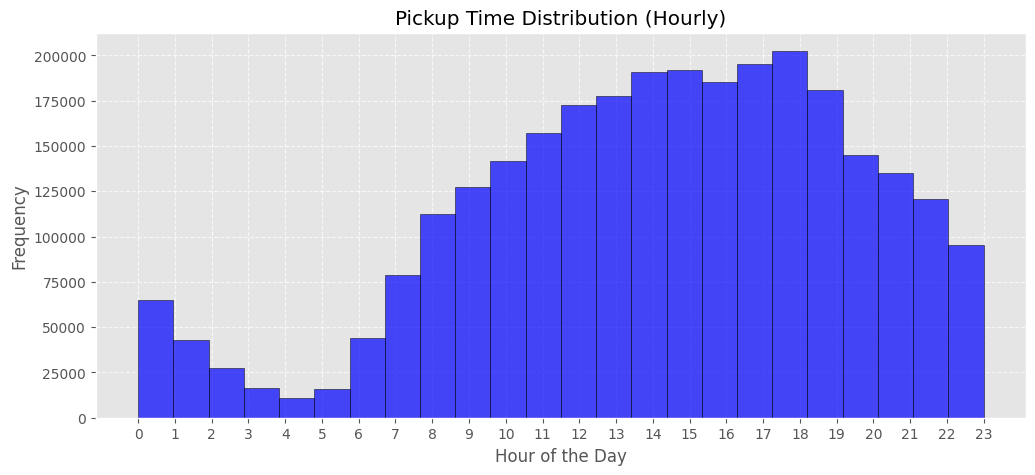

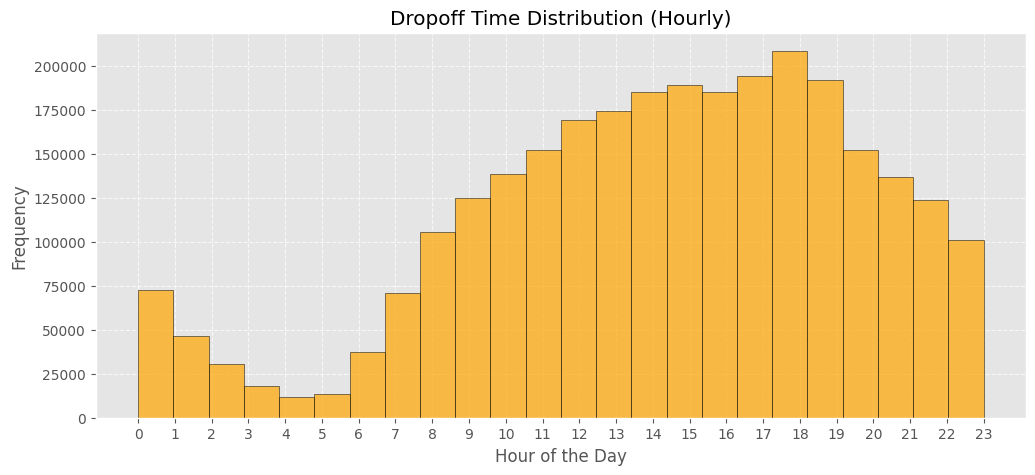

In [8]:
# ดึงข้อมูล pickup และ dropoff times
pickup_times = df.select("tpep_pickup_datetime").toPandas()
pickup_times["tpep_pickup_datetime"] = pd.to_datetime(pickup_times["tpep_pickup_datetime"])

dropoff_times = df.select("tpep_dropoff_datetime").toPandas()
dropoff_times["tpep_dropoff_datetime"] = pd.to_datetime(dropoff_times["tpep_dropoff_datetime"])

# สร้าง Histogram ของ pickup time
plt.figure(figsize=(12, 5))
plt.hist(pickup_times["tpep_pickup_datetime"].dt.hour, bins=24, edgecolor='k', alpha=0.7, color='blue')
plt.title("Pickup Time Distribution (Hourly)")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# สร้าง Histogram ของ dropoff time
plt.figure(figsize=(12, 5))
plt.hist(dropoff_times["tpep_dropoff_datetime"].dt.hour, bins=24, edgecolor='k', alpha=0.7, color='orange')
plt.title("Dropoff Time Distribution (Hourly)")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## trip duration

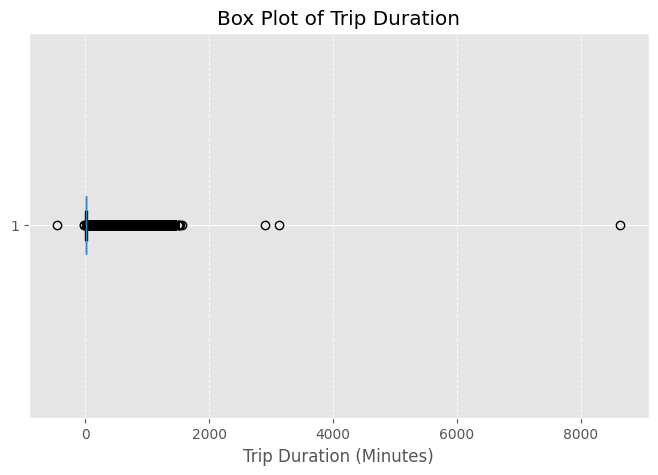

In [9]:
from pyspark.sql.functions import unix_timestamp

# คำนวณระยะเวลาเดินทางในหน่วยนาที
df_with_duration = df.withColumn(
    "trip_duration",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)

# ดึงข้อมูล trip_duration
trip_duration = df_with_duration.select("trip_duration").toPandas()

# สร้าง Box Plot ของ trip duration
plt.figure(figsize=(8, 5))
plt.boxplot(trip_duration["trip_duration"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.title("Box Plot of Trip Duration")
plt.xlabel("Trip Duration (Minutes)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


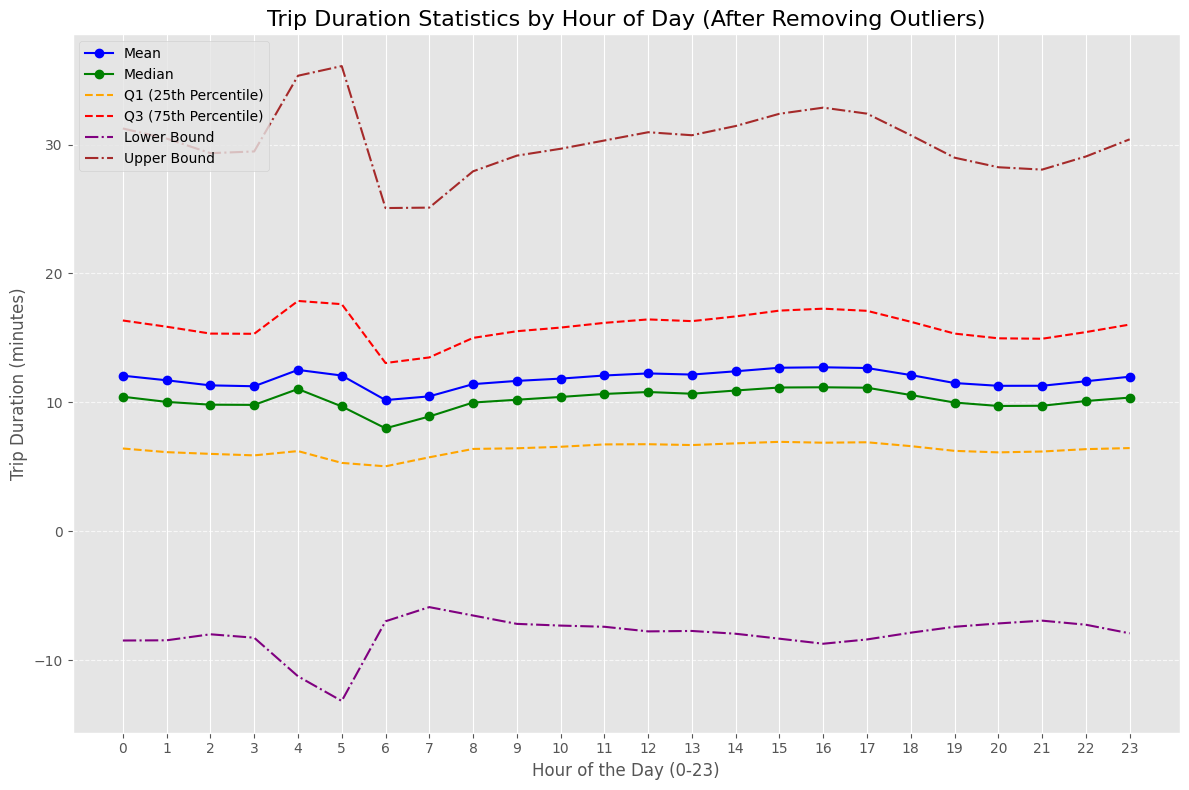

In [10]:

# Step 1: Add Trip Duration Column
df_with_duration = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)

# Step 2: Add Pickup Hour Column
df_with_duration = df_with_duration.withColumn("pickup_hour", hour("tpep_pickup_datetime"))

# Step 3: Calculate IQR and Define Outlier Boundaries
q1 = df_with_duration.approxQuantile("trip_duration_minutes", [0.25], 0)[0]
q3 = df_with_duration.approxQuantile("trip_duration_minutes", [0.75], 0)[0]
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter outliers
filtered_df = df_with_duration.filter(
    (col("trip_duration_minutes") >= lower_bound) & 
    (col("trip_duration_minutes") <= upper_bound)
)

# Step 4: Calculate Statistics Grouped by Hour
hourly_stats = filtered_df.groupBy("pickup_hour").agg(
    avg("trip_duration_minutes").alias("mean"),
    expr("percentile_approx(trip_duration_minutes, 0.5)").alias("median"),
    expr("percentile_approx(trip_duration_minutes, 0.25)").alias("q1"),
    expr("percentile_approx(trip_duration_minutes, 0.75)").alias("q3")
).orderBy("pickup_hour").toPandas()

# Calculate upper and lower bounds for each hour
hourly_stats["lower_bound"] = hourly_stats["q1"] - 1.5 * (hourly_stats["q3"] - hourly_stats["q1"])
hourly_stats["upper_bound"] = hourly_stats["q3"] + 1.5 * (hourly_stats["q3"] - hourly_stats["q1"])

# Step 5: Visualization
plt.figure(figsize=(12, 8))

# Plot mean and median
plt.plot(hourly_stats["pickup_hour"], hourly_stats["mean"], marker='o', label="Mean", color="blue")
plt.plot(hourly_stats["pickup_hour"], hourly_stats["median"], marker='o', label="Median", color="green")

# Plot Q1, Q3, Lower, and Upper Bounds
plt.plot(hourly_stats["pickup_hour"], hourly_stats["q1"], linestyle='--', label="Q1 (25th Percentile)", color="orange")
plt.plot(hourly_stats["pickup_hour"], hourly_stats["q3"], linestyle='--', label="Q3 (75th Percentile)", color="red")
plt.plot(hourly_stats["pickup_hour"], hourly_stats["lower_bound"], linestyle='-.', label="Lower Bound", color="purple")
plt.plot(hourly_stats["pickup_hour"], hourly_stats["upper_bound"], linestyle='-.', label="Upper Bound", color="brown")

# Customize the plot
plt.title("Trip Duration Statistics by Hour of Day (After Removing Outliers)", fontsize=16)
plt.xlabel("Hour of the Day (0-23)", fontsize=12)
plt.ylabel("Trip Duration (minutes)", fontsize=12)
plt.xticks(range(0, 24), fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(loc="upper left")
plt.tight_layout()

plt.show()

In [62]:
# แปลงเวลาที่ใช้ในการเดินทางเป็นนาที
df_with_duration = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60
)

# สร้างคอลัมน์ใหม่สำหรับการจัดกลุ่ม
df_grouped = df_with_duration.withColumn(
    "trip_duration_group",
    when(col("trip_duration_minutes") < 0, "Less than 0")
    .when(col("trip_duration_minutes") == 0, "Equal to 0")
    .otherwise("Greater than 0")
)

# นับจำนวนข้อมูลในแต่ละกลุ่ม
trip_duration_summary = (
    df_grouped.groupBy("trip_duration_group")
    .agg(count("*").alias("count"))
    .orderBy("trip_duration_group")
    .toPandas()
)

# คำนวณเปอร์เซ็นต์
total_count = trip_duration_summary["count"].sum()
trip_duration_summary["Percentage (%)"] = (trip_duration_summary["count"] / total_count) * 100

# แสดงผล
print("Summary of Trip Duration by Group:")
print(trip_duration_summary)


Summary of Trip Duration by Group:
  trip_duration_group    count  Percentage (%)
0          Equal to 0     2251        0.079421
1      Greater than 0  2829896       99.845886
2         Less than 0     2117        0.074693


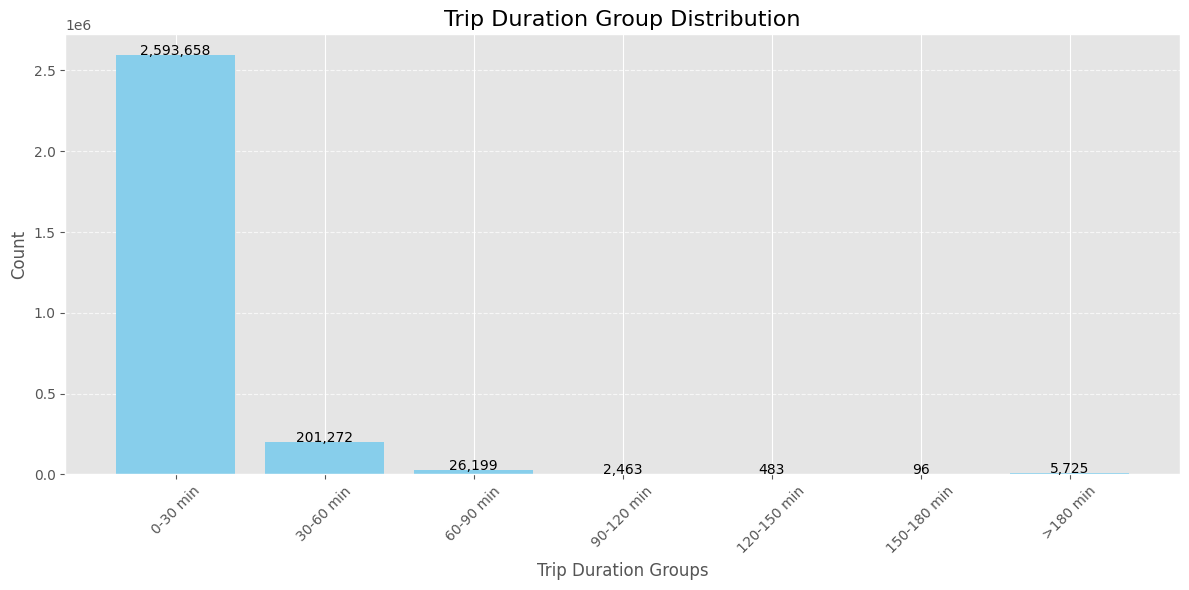

In [65]:
from pyspark.sql.functions import col, unix_timestamp, when
import matplotlib.pyplot as plt

# สร้าง column `trip_duration_minutes` (ระยะเวลาการเดินทางในนาที)
df_with_duration = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)

# Filter เฉพาะ trip_duration_minutes > 0
filtered_df = df_with_duration.filter(col("trip_duration_minutes") > 0)

# Add a new column for duration groups
grouped_df = filtered_df.withColumn(
    "trip_duration_group",
    when((col("trip_duration_minutes") > 0) & (col("trip_duration_minutes") <= 30), "0-30 min")
    .when((col("trip_duration_minutes") > 30) & (col("trip_duration_minutes") <= 60), "30-60 min")
    .when((col("trip_duration_minutes") > 60) & (col("trip_duration_minutes") <= 90), "60-90 min")
    .when((col("trip_duration_minutes") > 90) & (col("trip_duration_minutes") <= 120), "90-120 min")
    .when((col("trip_duration_minutes") > 120) & (col("trip_duration_minutes") <= 150), "120-150 min")
    .when((col("trip_duration_minutes") > 150) & (col("trip_duration_minutes") <= 180), "150-180 min")
    .otherwise(">180 min")
)

# Group by duration group and count
duration_group_summary = (
    grouped_df.groupBy("trip_duration_group")
    .count()
    .orderBy("trip_duration_group")
    .toPandas()
)

# Sorting the categories manually for better order
categories = ["0-30 min", "30-60 min", "60-90 min", "90-120 min", "120-150 min", "150-180 min", ">180 min"]
duration_group_summary = duration_group_summary.set_index("trip_duration_group").reindex(categories).reset_index()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(duration_group_summary["trip_duration_group"], duration_group_summary["count"], color="skyblue")

# Add count labels on each bar
for bar, count in zip(bars, duration_group_summary["count"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        bar.get_height() + 100,  # Y position (slightly above the bar)
        f"{count:,}",  # Format count with commas
        ha='center', fontsize=10, color='black'
    )

# Customize plot
plt.title("Trip Duration Group Distribution", fontsize=16)
plt.xlabel("Trip Duration Groups", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


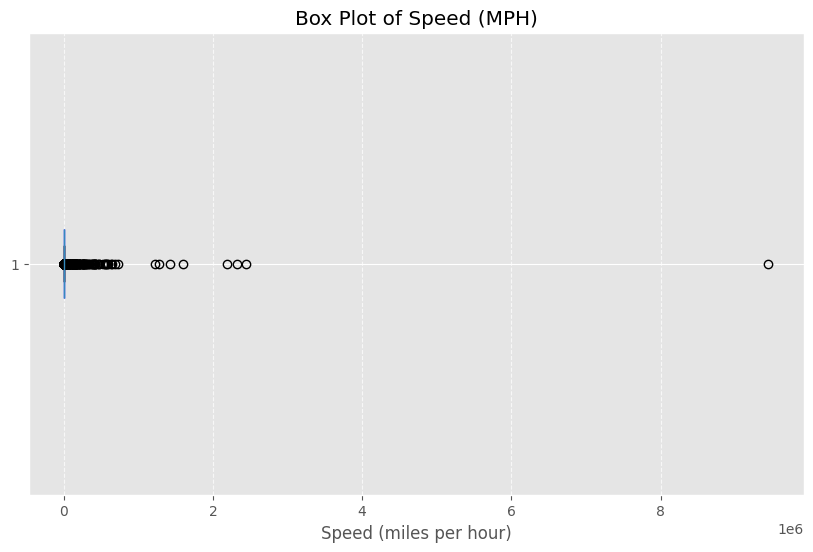

In [66]:
from pyspark.sql.functions import col, unix_timestamp

# 1. กรอง trip_duration ที่มากกว่า 0
df_with_duration = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
).filter(col("trip_duration_minutes") > 0)

# 2. กรอง trip_distance ที่มากกว่า 0
df_with_distance = df_with_duration.filter(col("trip_distance") > 0)

# 3. คำนวณอัตราเร็ว (trip_distance / trip_duration_minutes)
df_with_speed = df_with_distance.withColumn(
    "speed_mph",
    col("trip_distance") / (col("trip_duration_minutes") / 60)  # คำนวณความเร็วในหน่วย mph
)

# แปลง DataFrame เป็น Pandas DataFrame เพื่อการวิเคราะห์เพิ่มเติม
speed_data = df_with_speed.select("speed_mph").toPandas()

# 4. สร้าง Box Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(speed_data["speed_mph"], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.title("Box Plot of Speed (MPH)")
plt.xlabel("Speed (miles per hour)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## passenger_count

In [11]:
# Group by passenger_count and count each category
passenger_count_stats = df.groupBy("passenger_count").count().orderBy("passenger_count").toPandas()

# Calculate the total count
total_passenger_count = passenger_count_stats["count"].sum()

# Calculate the percentage for each category
passenger_count_stats["Percentage (%)"] = (passenger_count_stats["count"] / total_passenger_count) * 100

# Rename columns for clarity
passenger_count_stats.columns = ["Passenger Count", "Count", "Percentage (%)"]

# Display the results
print("Passenger Count Statistics:")
print(passenger_count_stats)


Passenger Count Statistics:
    Passenger Count    Count  Percentage (%)
0               NaN   123538        4.358733
1               0.0    66636        2.351087
2               1.0  1968440       69.451540
3               2.0   412798       14.564557
4               3.0   108634        3.832882
5               4.0    40950        1.444820
6               5.0    67686        2.388133
7               6.0    45562        1.607543
8               7.0       11        0.000388
9               8.0        5        0.000176
10              9.0        4        0.000141


In [54]:
# Remove NaN values from passenger_count
df_filtered = df.filter(col("passenger_count").isNotNull())

# Group by passenger_count and count each category
passenger_count_stats = df_filtered.groupBy("passenger_count").count().orderBy("passenger_count").toPandas()

# Calculate the total count
total_passenger_count = passenger_count_stats["count"].sum()

# Calculate the percentage for each category
passenger_count_stats["Percentage (%)"] = (passenger_count_stats["count"] / total_passenger_count) * 100

# Rename columns for clarity
passenger_count_stats.columns = ["Passenger Count", "Count", "Percentage (%)"]

# Calculate the median of passenger_count
passenger_count_median = df_filtered.select("passenger_count").toPandas()["passenger_count"].median()

# Display the results
print("Passenger Count Statistics (After Removing NaN):")
print(passenger_count_stats)
print(f"\nMedian of Passenger Count (After Removing NaN): {passenger_count_median}")


Passenger Count Statistics (After Removing NaN):
   Passenger Count    Count  Percentage (%)
0              0.0    66636        2.458234
1              1.0  1968440       72.616709
2              2.0   412798       15.228319
3              3.0   108634        4.007561
4              4.0    40950        1.510665
5              5.0    67686        2.496969
6              6.0    45562        1.680804
7              7.0       11        0.000406
8              8.0        5        0.000184
9              9.0        4        0.000148

Median of Passenger Count (After Removing NaN): 1.0


In [55]:
# คำนวณ Median โดยไม่กรอง NaN ออก
passenger_count_median_without_filter = df.select("passenger_count").toPandas()["passenger_count"].median()

print(f"Median of Passenger Count (Without Removing NaN): {passenger_count_median_without_filter}")


Median of Passenger Count (Without Removing NaN): 1.0


## trip_distance

In [56]:
# สร้างคอลัมน์ใหม่สำหรับการจัดกลุ่ม
trip_distance_grouped = df.withColumn(
    "trip_distance_group",
    when(col("trip_distance") > 0, "Greater than Zero")
    .when(col("trip_distance") < 0, "Less than Zero")
    .otherwise("Equal to Zero")
)

# นับจำนวนในแต่ละกลุ่ม
trip_distance_summary = (
    trip_distance_grouped.groupBy("trip_distance_group")
    .agg(count("*").alias("count"))
    .orderBy("trip_distance_group")
    .toPandas()
)

# คำนวณเปอร์เซ็นต์
total_count = trip_distance_summary["count"].sum()
trip_distance_summary["percentage"] = (trip_distance_summary["count"] / total_count) * 100

# เปลี่ยนชื่อคอลัมน์เพื่อให้อ่านง่าย
trip_distance_summary.columns = ["Trip Distance Group", "Count", "Percentage (%)"]

# แสดงผล
print("Summary of Trip Distance by Group:")
print(trip_distance_summary)


Summary of Trip Distance by Group:
  Trip Distance Group    Count  Percentage (%)
0       Equal to Zero    34150        1.204898
1   Greater than Zero  2800114       98.795102


/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


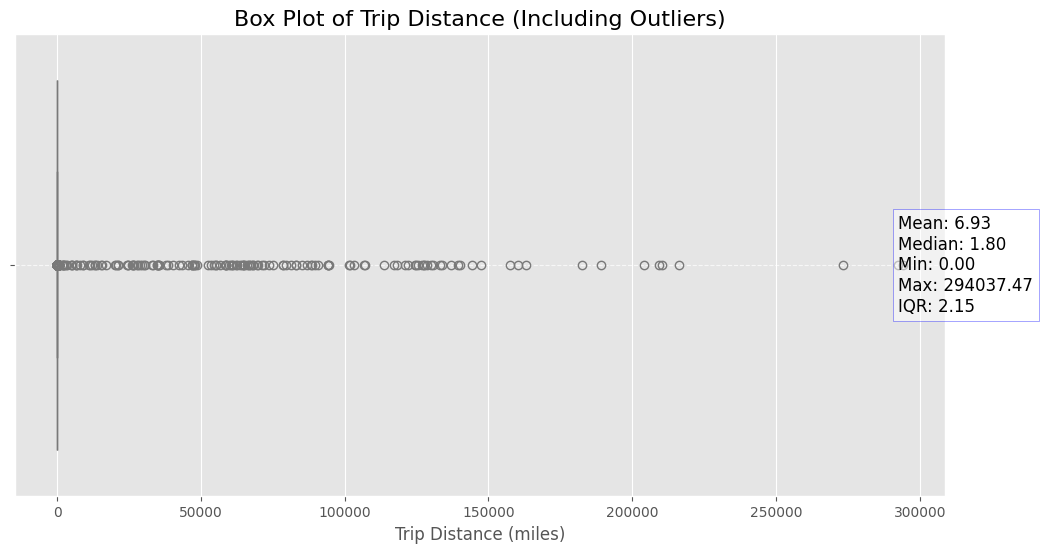

In [13]:
# ดึงข้อมูล trip_distance จาก Spark DataFrame
trip_distance = df.select("trip_distance").toPandas()

# คำนวณค่าทางสถิติ
mean_distance = trip_distance["trip_distance"].mean()
median_distance = trip_distance["trip_distance"].median()
min_distance = trip_distance["trip_distance"].min()
max_distance = trip_distance["trip_distance"].max()
q1 = trip_distance["trip_distance"].quantile(0.25)
q3 = trip_distance["trip_distance"].quantile(0.75)
iqr = q3 - q1

# สร้าง Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=trip_distance, x="trip_distance", color="lightblue")

# เพิ่มค่าทางสถิติที่มุมขวาบน
plt.text(
    0.95, 0.5, 
    f"Mean: {mean_distance:.2f}\nMedian: {median_distance:.2f}\nMin: {min_distance:.2f}\nMax: {max_distance:.2f}\nIQR: {iqr:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Trip Distance (Including Outliers)", fontsize=16)
plt.xlabel("Trip Distance (miles)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


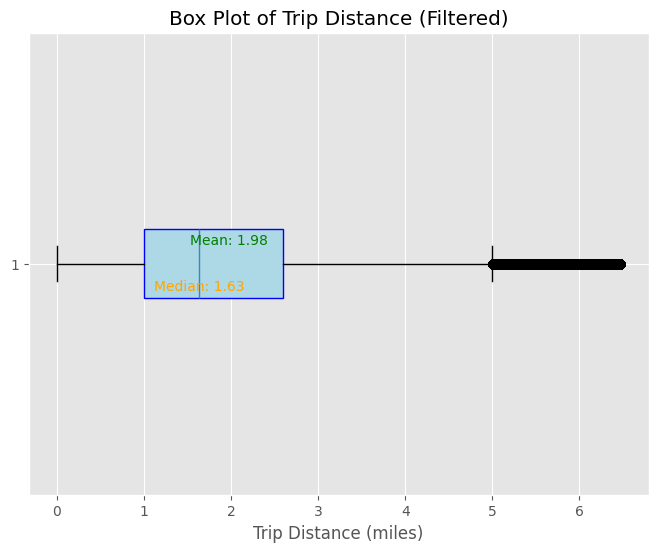

In [14]:
# ดึงข้อมูล trip_distance จาก DataFrame
trip_distance = df.select("trip_distance").toPandas()

# คำนวณ IQR เพื่อกรอง Outliers
Q1 = trip_distance["trip_distance"].quantile(0.25)
Q3 = trip_distance["trip_distance"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# กรองข้อมูลเพื่อเอา Outliers ออก
filtered_trip_distance = trip_distance[
    (trip_distance["trip_distance"] >= lower_bound) & 
    (trip_distance["trip_distance"] <= upper_bound)
]

# สร้าง Box Plot
plt.figure(figsize=(8, 6))
plt.boxplot(filtered_trip_distance["trip_distance"], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.title("Box Plot of Trip Distance (Filtered)")
plt.xlabel("Trip Distance (miles)")

# เพิ่มข้อมูลค่าสถิติในกราฟ
mean = filtered_trip_distance["trip_distance"].mean()
median = filtered_trip_distance["trip_distance"].median()
plt.text(mean, 1.05, f"Mean: {mean:.2f}", ha='center', va='center', color='green')
plt.text(median, 0.95, f"Median: {median:.2f}", ha='center', va='center', color='orange')

plt.show()

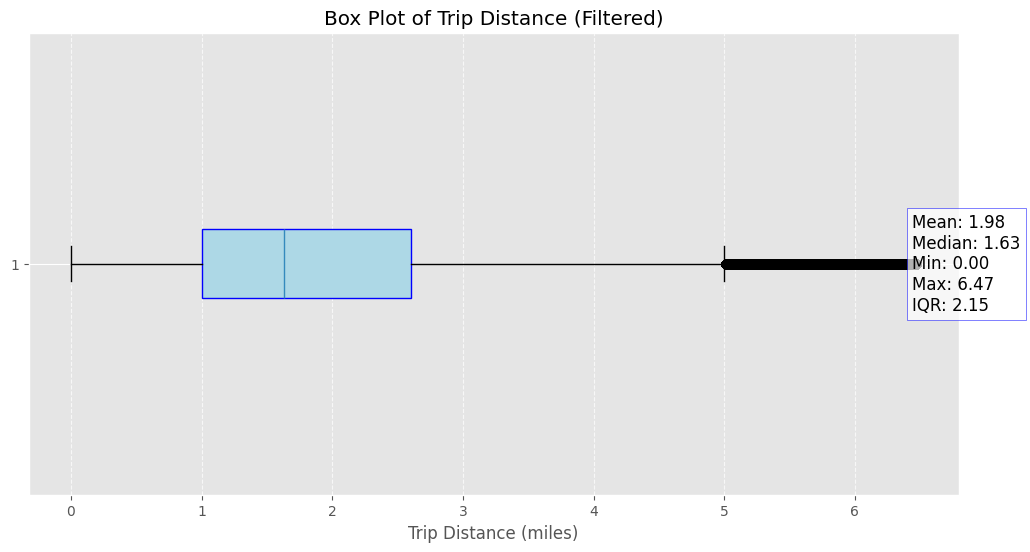

In [15]:
# ดึงข้อมูล trip_distance จาก DataFrame
trip_distance = df.select("trip_distance").toPandas()

# คำนวณ IQR เพื่อกรอง Outliers
Q1 = trip_distance["trip_distance"].quantile(0.25)
Q3 = trip_distance["trip_distance"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# กรองข้อมูลเพื่อเอา Outliers ออก
filtered_trip_distance = trip_distance[
    (trip_distance["trip_distance"] >= lower_bound) & 
    (trip_distance["trip_distance"] <= upper_bound)
]

# คำนวณค่าสถิติที่สำคัญ
mean = filtered_trip_distance["trip_distance"].mean()
median = filtered_trip_distance["trip_distance"].median()
min_value = filtered_trip_distance["trip_distance"].min()
max_value = filtered_trip_distance["trip_distance"].max()
iqr = IQR

# สร้าง Box Plot
plt.figure(figsize=(12, 6))
plt.boxplot(filtered_trip_distance["trip_distance"], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.title("Box Plot of Trip Distance (Filtered)")
plt.xlabel("Trip Distance (miles)")

# เพิ่มข้อมูลค่าสถิติในกล่องข้อความด้านขวา
plt.text(
    0.95, 0.5, 
    f"Mean: {mean:.2f}\nMedian: {median:.2f}\nMin: {min_value:.2f}\nMax: {max_value:.2f}\nIQR: {iqr:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.7)
)

# ตั้งค่า Grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


In [58]:
# คำนวณ Mean และ Standard Deviation
stats = df.select(mean(col("trip_distance")), stddev(col("trip_distance"))).first()
mean_value = stats[0]
std_dev = stats[1]

# กำหนด Z-score threshold (เช่น Z = 3)
z_score_threshold = 3
lower_z_bound = mean_value - z_score_threshold * std_dev
upper_z_bound = mean_value + z_score_threshold * std_dev

# กรองข้อมูลให้อยู่ในช่วงที่สมเหตุสมผล
filtered_df_zscore = df.filter((col("trip_distance") >= lower_z_bound) & (col("trip_distance") <= upper_z_bound))

# แสดงข้อมูลหลังการกรอง
filtered_df_zscore.select("trip_distance").describe().show()

# Optional: ดู Boundaries
print(f"Mean: {mean_value}, Std Dev: {std_dev}, Lower Bound: {lower_z_bound}, Upper Bound: {upper_z_bound}")


+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|           2834116|
|   mean|3.1390800941102706|
| stddev| 4.735394704461214|
|    min|               0.0|
|    max|           1983.84|
+-------+------------------+

Mean: 6.933757553989049, Std Dev: 671.9295004775662, Lower Bound: -2008.8547438787093, Upper Bound: 2022.7222589866876


In [60]:
# สร้างคอลัมน์ใหม่สำหรับการจัดกลุ่ม (จากข้อมูลที่ยังไม่กรอง)
trip_distance_grouped_raw = df.withColumn(
    "trip_distance_group",
    when(col("trip_distance") < 0, "Less than Zero")
    .when(col("trip_distance") == 0, "Equal to Zero")
    .when((col("trip_distance") > 0) & (col("trip_distance") <= 150), "Greater than Zero and <= 150 miles")
    .otherwise("Greater than 150 miles")
)

# นับจำนวนในแต่ละกลุ่ม
trip_distance_summary_raw = (
    trip_distance_grouped_raw.groupBy("trip_distance_group")
    .agg(count("*").alias("count"))
    .orderBy("trip_distance_group")
    .toPandas()
)

# คำนวณเปอร์เซ็นต์
total_count_raw = trip_distance_summary_raw["count"].sum()
trip_distance_summary_raw["Percentage (%)"] = (trip_distance_summary_raw["count"] / total_count_raw) * 100

# แสดงผลลัพธ์
print("Summary of Trip Distance by Group (Raw Data):")
print(trip_distance_summary_raw)

Summary of Trip Distance by Group (Raw Data):
                  trip_distance_group    count  Percentage (%)
0                       Equal to Zero    34150        1.204898
1              Greater than 150 miles      221        0.007797
2  Greater than Zero and <= 150 miles  2799893       98.787304


## PULocationID และ DOLocationID

In [16]:
# ดึง distinct values ของ PULocationID
pu_distinct = df.select("PULocationID").distinct().orderBy("PULocationID")
pu_values = pu_distinct.toPandas()

# ดึง distinct values ของ DOLocationID
do_distinct = df.select("DOLocationID").distinct().orderBy("DOLocationID")
do_values = do_distinct.toPandas()

# แสดงผล
print("Distinct PULocationID:")
print(pu_values)

print("\nDistinct DOLocationID:")
print(do_values)


Distinct PULocationID:
     PULocationID
0               1
1               3
2               4
3               5
4               6
..            ...
256           261
257           262
258           263
259           264
260           265

[261 rows x 1 columns]

Distinct DOLocationID:
     DOLocationID
0               1
1               2
2               3
3               4
4               5
..            ...
256           261
257           262
258           263
259           264
260           265

[261 rows x 1 columns]


## RateCodeID

In [17]:
# นับจำนวนในแต่ละ RatecodeID
ratecode_count = df.groupBy("RatecodeID").count().orderBy("RatecodeID").toPandas()

# Mapping RatecodeID กับ Category
ratecode_mapping = {
    1: "Standard rate",
    2: "JFK",
    3: "Newark",
    4: "Nassau or Westchester",
    5: "Negotiated fare",
    6: "Group ride"
}

# เพิ่มคอลัมน์ Category
ratecode_count["Category"] = ratecode_count["RatecodeID"].map(ratecode_mapping)

# คำนวณเปอร์เซ็นต์
total_count = ratecode_count["count"].sum()
ratecode_count["Percentage (%)"] = (ratecode_count["count"] / total_count) * 100

# จัดเรียงคอลัมน์ใหม่เพื่อความชัดเจน
ratecode_count = ratecode_count[["RatecodeID", "Category", "count", "Percentage (%)"]]

# แสดงผล
print("RatecodeID Counts and Percentages by Category:")
print(ratecode_count)


RatecodeID Counts and Percentages by Category:
   RatecodeID               Category    count  Percentage (%)
0         NaN                    NaN   123538        4.358733
1         1.0          Standard rate  2632863       92.894064
2         2.0                    JFK    58945        2.079729
3         3.0                 Newark     3971        0.140107
4         4.0  Nassau or Westchester     3125        0.110258
5         5.0        Negotiated fare    11628        0.410265
6         6.0             Group ride       21        0.000741
7        99.0                    NaN      173        0.006104


## store_and_fwd_flag

In [18]:
# นับจำนวนในแต่ละค่า store_and_fwd_flag
store_and_fwd_count = df.groupBy("store_and_fwd_flag").count().orderBy("store_and_fwd_flag").toPandas()

# Mapping store_and_fwd_flag กับ Category
store_and_fwd_mapping = {
    "Y": "Yes (Stored and Forwarded)",
    "N": "No (Not Stored and Forwarded)"
}

# เพิ่มคอลัมน์ Category
store_and_fwd_count["Category"] = store_and_fwd_count["store_and_fwd_flag"].map(store_and_fwd_mapping)

# คำนวณสัดส่วนเป็น %
total_count = store_and_fwd_count["count"].sum()
store_and_fwd_count["Percentage (%)"] = (store_and_fwd_count["count"] / total_count) * 100

# แสดงผล
print("Store and Forward Flag Counts by Category with Percentage:")
print(store_and_fwd_count[["store_and_fwd_flag", "Category", "count", "Percentage (%)"]])


Store and Forward Flag Counts by Category with Percentage:
  store_and_fwd_flag                       Category    count  Percentage (%)
0               None                            NaN   123538        4.358733
1                  N  No (Not Stored and Forwarded)  2686695       94.793393
2                  Y     Yes (Stored and Forwarded)    24031        0.847874


## Payment_type 

In [19]:
# นับจำนวนในแต่ละค่า payment_type
payment_type_count = df.groupBy("payment_type").count().orderBy("payment_type").toPandas()

# Mapping payment_type กับ Category
payment_type_mapping = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
}

# เพิ่มคอลัมน์ Category
payment_type_count["Category"] = payment_type_count["payment_type"].map(payment_type_mapping)

# คำนวณสัดส่วนเป็น %
total_count = payment_type_count["count"].sum()
payment_type_count["Percentage (%)"] = (payment_type_count["count"] / total_count) * 100

# แสดงผล
print("Payment Type Counts by Category with Percentage:")
print(payment_type_count[["payment_type", "Category", "count", "Percentage (%)"]])


Payment Type Counts by Category with Percentage:
   payment_type     Category    count  Percentage (%)
0             0          NaN   123538        4.358733
1             1  Credit card  2078122       73.321398
2             2         Cash   607908       21.448531
3             3    No charge    13380        0.472080
4             4      Dispute    11316        0.399257


## Fare_amount 

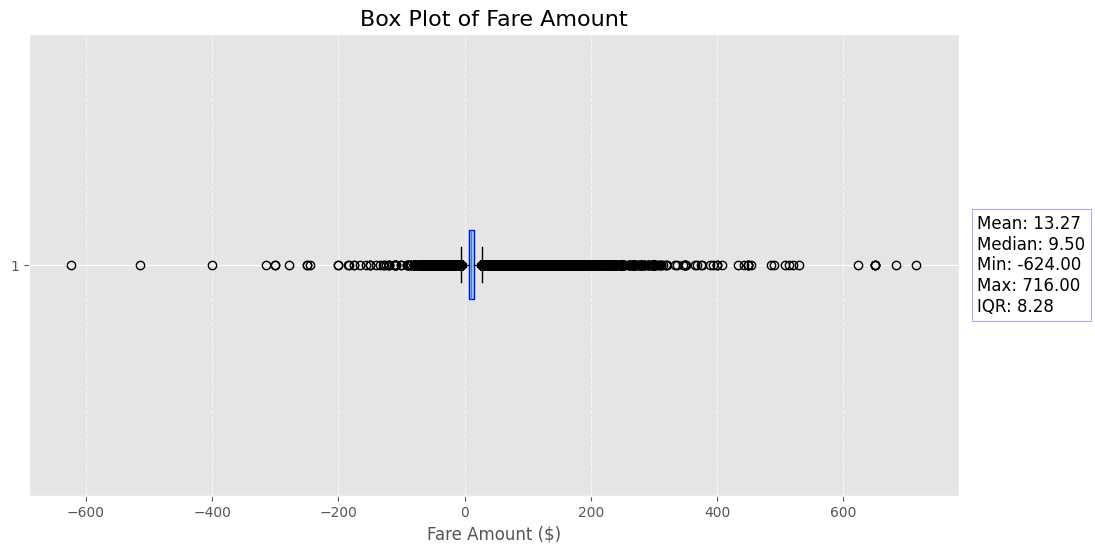

In [20]:
# ดึงข้อมูล fare_amount
fare_data = df.select("fare_amount").toPandas()

# คำนวณค่าสถิติที่สำคัญ
mean_fare = fare_data["fare_amount"].mean()
median_fare = fare_data["fare_amount"].median()
min_fare = fare_data["fare_amount"].min()
max_fare = fare_data["fare_amount"].max()
q1 = fare_data["fare_amount"].quantile(0.25)
q3 = fare_data["fare_amount"].quantile(0.75)
iqr = q3 - q1

# สร้าง Box Plot
plt.figure(figsize=(12, 6))
plt.boxplot(fare_data["fare_amount"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))

# เพิ่มข้อความแสดงค่าสถิติที่มุมขวาบน
plt.text(
    1.02, 0.5, 
    f"Mean: {mean_fare:.2f}\nMedian: {median_fare:.2f}\nMin: {min_fare:.2f}\nMax: {max_fare:.2f}\nIQR: {iqr:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Fare Amount", fontsize=16)
plt.xlabel("Fare Amount ($)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


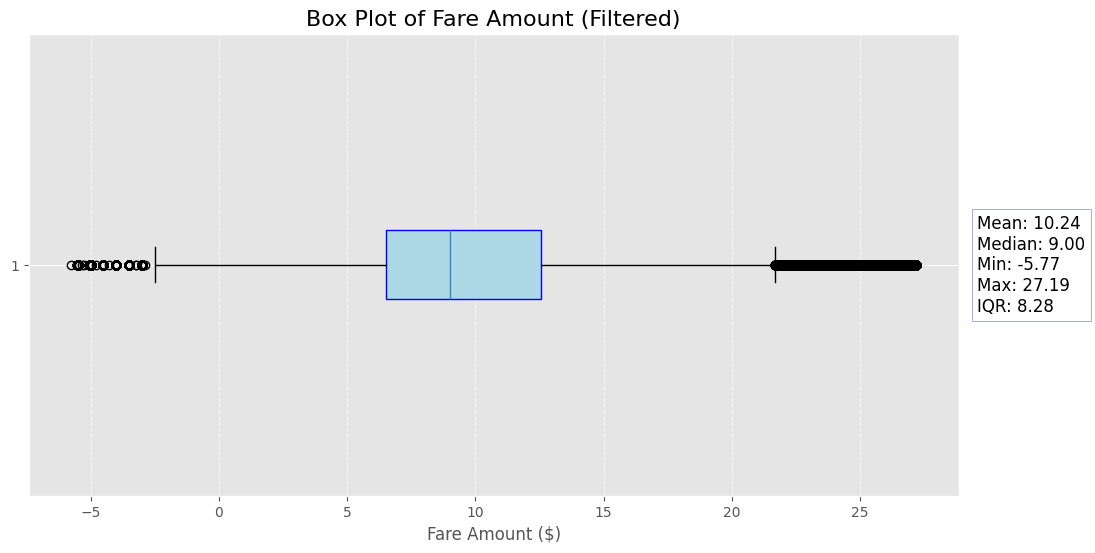

In [21]:
# ดึงข้อมูล fare_amount
fare_data = df.select("fare_amount").toPandas()

# คำนวณ IQR เพื่อกรอง Outliers
q1 = fare_data["fare_amount"].quantile(0.25)
q3 = fare_data["fare_amount"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# กรองข้อมูลเพื่อเอา Outliers ออก
filtered_fare_data = fare_data[
    (fare_data["fare_amount"] >= lower_bound) & 
    (fare_data["fare_amount"] <= upper_bound)
]

# คำนวณค่าสถิติที่สำคัญ
mean_fare = filtered_fare_data["fare_amount"].mean()
median_fare = filtered_fare_data["fare_amount"].median()
min_fare = filtered_fare_data["fare_amount"].min()
max_fare = filtered_fare_data["fare_amount"].max()
iqr = q3 - q1

# สร้าง Box Plot
plt.figure(figsize=(12, 6))
plt.boxplot(filtered_fare_data["fare_amount"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))

# เพิ่มข้อความแสดงค่าสถิติที่มุมขวาบน
plt.text(
    1.02, 0.5, 
    f"Mean: {mean_fare:.2f}\nMedian: {median_fare:.2f}\nMin: {min_fare:.2f}\nMax: {max_fare:.2f}\nIQR: {iqr:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Fare Amount (Filtered)", fontsize=16)
plt.xlabel("Fare Amount ($)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


+-----------------+-------+-------------------+
|       fare_group|  count|     Percentage (%)|
+-----------------+-------+-------------------+
|    Equal to Zero|   1117|0.03941058419399181|
|Greater than Zero|2820584|  99.51733501184081|
|   Less than Zero|  12563| 0.4432544039651916|
+-----------------+-------+-------------------+



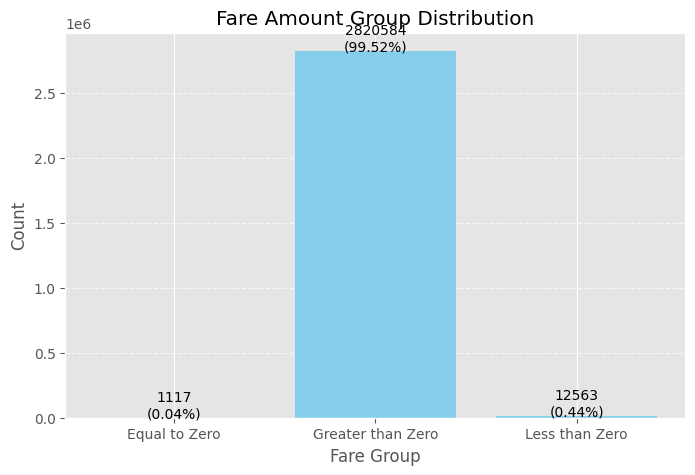

In [52]:
from pyspark.sql.functions import col, when, count

# สร้างกลุ่มของ fare_amount
fare_grouped = df.withColumn(
    "fare_group",
    when(col("fare_amount") < 0, "Less than Zero")
    .when(col("fare_amount") == 0, "Equal to Zero")
    .otherwise("Greater than Zero")
)

# คำนวณจำนวนและเปอร์เซ็นต์ในแต่ละกลุ่ม
fare_summary = fare_grouped.groupBy("fare_group").agg(
    count("*").alias("count")
).orderBy("fare_group")

total_count = fare_summary.selectExpr("SUM(count) as total").collect()[0]["total"]
fare_summary = fare_summary.withColumn(
    "Percentage (%)", (col("count") / total_count) * 100
)

# แสดงผล
fare_summary.show()

# หากต้องการแปลงเป็น Pandas DataFrame สำหรับการ visualize
fare_summary_pd = fare_summary.toPandas()

# สร้าง Bar Chart แสดงผล
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(fare_summary_pd["fare_group"], fare_summary_pd["count"], color="skyblue")
for i, val in enumerate(fare_summary_pd["count"]):
    plt.text(i, val + 500, f"{val}\n({fare_summary_pd['Percentage (%)'][i]:.2f}%)", ha='center', fontsize=10)

plt.title("Fare Amount Group Distribution")
plt.xlabel("Fare Group")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


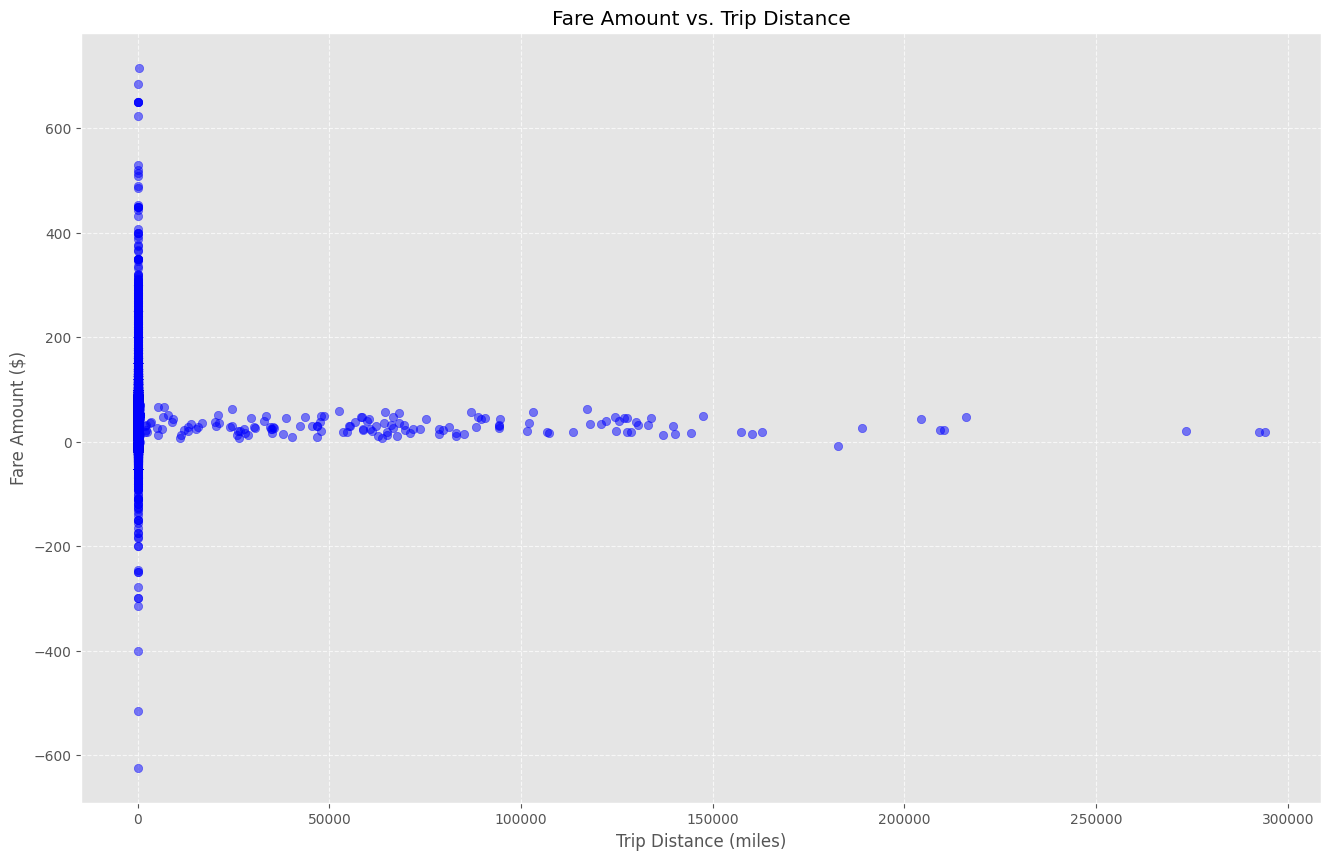

In [22]:
# ดึงข้อมูล fare_amount และ trip_distance
fare_trip_data = df.select("fare_amount", "trip_distance").toPandas()

# สร้าง Scatter Plot
plt.figure(figsize=(16, 10))
plt.scatter(fare_trip_data["trip_distance"], fare_trip_data["fare_amount"], alpha=0.5, color="blue")
plt.title("Fare Amount vs. Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
# plt.xlim(0, 30)  # กำหนดช่วงระยะทาง
# plt.ylim(0, 100)  # กำหนดช่วงค่าโดยสาร
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


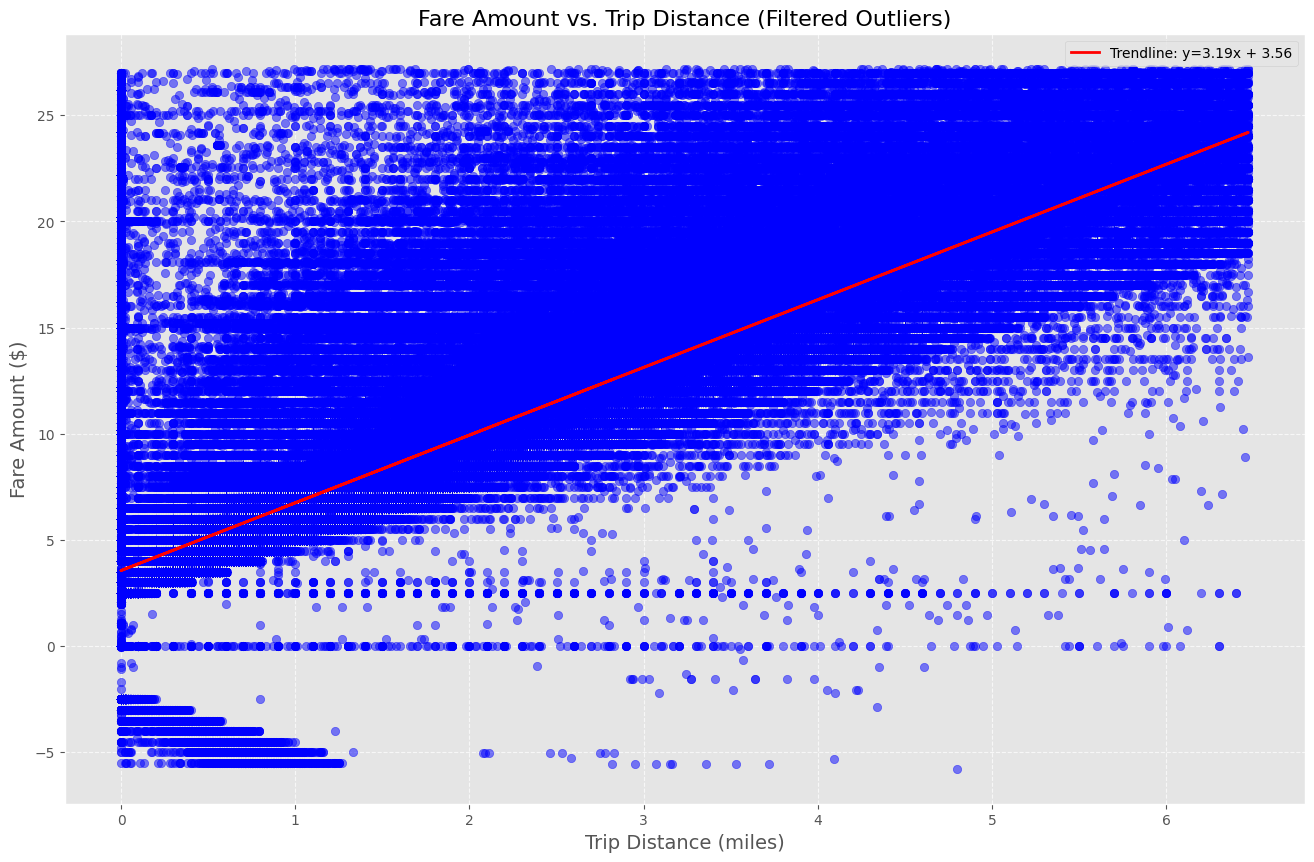

In [23]:
# ดึงข้อมูล fare_amount และ trip_distance
fare_trip_data = df.select("fare_amount", "trip_distance").toPandas()

# คำนวณ IQR เพื่อกรอง Outliers
q1_fare = fare_trip_data["fare_amount"].quantile(0.25)
q3_fare = fare_trip_data["fare_amount"].quantile(0.75)
iqr_fare = q3_fare - q1_fare
lower_bound_fare = q1_fare - 1.5 * iqr_fare
upper_bound_fare = q3_fare + 1.5 * iqr_fare

q1_distance = fare_trip_data["trip_distance"].quantile(0.25)
q3_distance = fare_trip_data["trip_distance"].quantile(0.75)
iqr_distance = q3_distance - q1_distance
lower_bound_distance = q1_distance - 1.5 * iqr_distance
upper_bound_distance = q3_distance + 1.5 * iqr_distance

# กรองข้อมูลเพื่อเอา Outliers ออก
filtered_fare_trip_data = fare_trip_data[
    (fare_trip_data["fare_amount"] >= lower_bound_fare) & 
    (fare_trip_data["fare_amount"] <= upper_bound_fare) & 
    (fare_trip_data["trip_distance"] >= lower_bound_distance) & 
    (fare_trip_data["trip_distance"] <= upper_bound_distance)
]

# สร้าง Scatter Plot
plt.figure(figsize=(16, 10))
plt.scatter(filtered_fare_trip_data["trip_distance"], filtered_fare_trip_data["fare_amount"], 
            alpha=0.5, color="blue")
plt.title("Fare Amount vs. Trip Distance (Filtered Outliers)", fontsize=16)
plt.xlabel("Trip Distance (miles)", fontsize=14)
plt.ylabel("Fare Amount ($)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# เพิ่มเส้นแนวโน้ม (Optional)
z = np.polyfit(filtered_fare_trip_data["trip_distance"], filtered_fare_trip_data["fare_amount"], 1)
p = np.poly1d(z)
plt.plot(filtered_fare_trip_data["trip_distance"], p(filtered_fare_trip_data["trip_distance"]), 
         color="red", linewidth=2, label=f"Trendline: y={z[0]:.2f}x + {z[1]:.2f}")
plt.legend()

plt.show()


## Extra 

/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


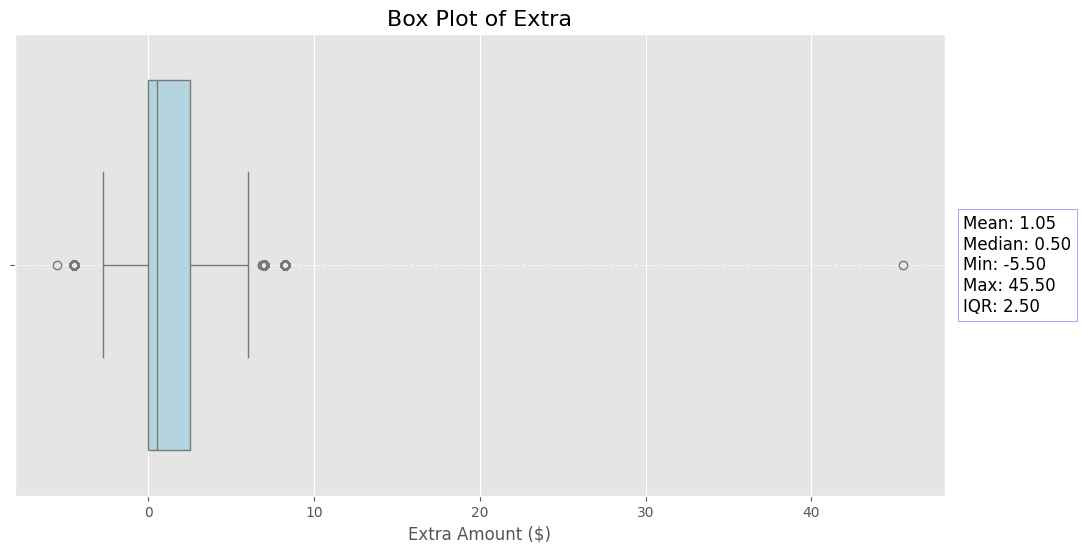

In [24]:
# ดึงข้อมูล "extra" จาก DataFrame
extra_data = df.select("extra").toPandas()

# คำนวณค่าสถิติที่สำคัญ
mean_extra = extra_data["extra"].mean()
median_extra = extra_data["extra"].median()
min_extra = extra_data["extra"].min()
max_extra = extra_data["extra"].max()
q1_extra = extra_data["extra"].quantile(0.25)
q3_extra = extra_data["extra"].quantile(0.75)
iqr_extra = q3_extra - q1_extra

# สร้าง Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x=extra_data["extra"], color="lightblue")

# เพิ่มข้อความแสดงค่าสถิติที่มุมขวาบน
plt.text(
    1.02, 0.5, 
    f"Mean: {mean_extra:.2f}\nMedian: {median_extra:.2f}\nMin: {min_extra:.2f}\nMax: {max_extra:.2f}\nIQR: {iqr_extra:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Extra", fontsize=16)
plt.xlabel("Extra Amount ($)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# แสดงกราฟ
plt.show()


Summary of Extra by Category:
  Category    count  Percentage (%)
0      0.5   448801       15.834834
1      1.0   389642       13.747555
2    Other  1995821       70.417611


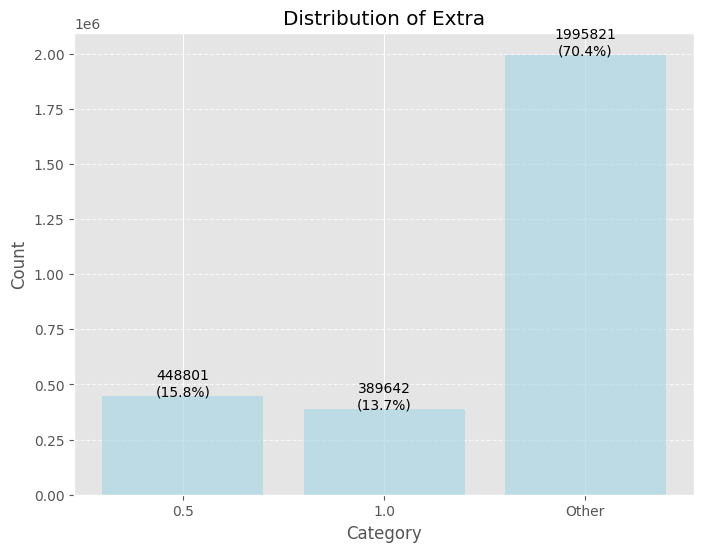

In [25]:
# สร้างคอลัมน์ Category โดยกำหนดเงื่อนไข
df_with_category = df.withColumn(
    "Category",
    when(df["Extra"] == 0.5, "0.5")
    .when(df["Extra"] == 1.0, "1.0")
    .otherwise("Other")
)

# นับจำนวนในแต่ละ Category
extra_summary = (
    df_with_category.groupBy("Category")
    .count()
    .orderBy("Category")
    .toPandas()
)

# คำนวณเปอร์เซ็นต์
total_count = extra_summary["count"].sum()
extra_summary["Percentage (%)"] = (extra_summary["count"] / total_count) * 100

# แสดงผล
print("Summary of Extra by Category:")
print(extra_summary)

# Optional: Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(extra_summary["Category"], extra_summary["count"], color="lightblue", alpha=0.7)

# เพิ่มตัวเลขจำนวนและ % บนแท่ง
for i, val in enumerate(extra_summary["count"]):
    plt.text(i, val + 10, f"{val}\n({extra_summary['Percentage (%)'][i]:.1f}%)", ha='center')

plt.title("Distribution of Extra")
plt.xlabel("Category")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


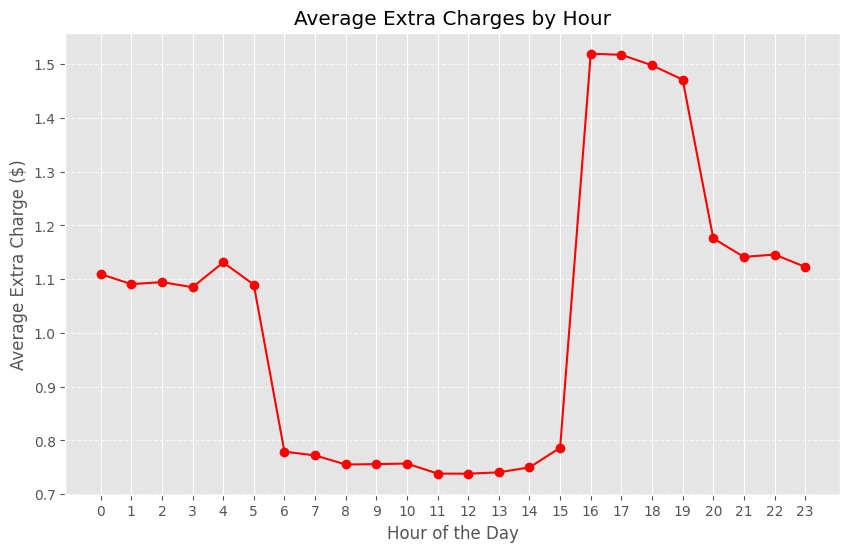

In [26]:
from pyspark.sql.functions import hour

# เพิ่มคอลัมน์ hour
df = df.withColumn("hour", hour("tpep_pickup_datetime"))

# คำนวณค่าเฉลี่ย Extra ในแต่ละชั่วโมง
extra_hour_data = df.groupBy("hour").avg("extra").orderBy("hour").toPandas()

# สร้าง Line Chart
plt.figure(figsize=(10, 6))
plt.plot(extra_hour_data["hour"], extra_hour_data["avg(extra)"], marker="o", color="red")
plt.title("Average Extra Charges by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Extra Charge ($)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 24))
plt.show()


## MTA_tax 

In [27]:
# นับจำนวนในแต่ละค่า MTA_tax
mta_tax_count = df.groupBy("MTA_tax").count().orderBy("MTA_tax").toPandas()

# คำนวณเปอร์เซ็นต์
total_count = mta_tax_count["count"].sum()
mta_tax_count["Percentage (%)"] = (mta_tax_count["count"] / total_count) * 100

# แสดงผล
print("MTA_tax Counts and Percentages:")
print(mta_tax_count)


MTA_tax Counts and Percentages:
   MTA_tax    count  Percentage (%)
0     -0.5    12225        0.431329
1      0.0    16133        0.569213
2      0.5  2805905       98.999423
3      3.5        1        0.000035


## Improvement_surcharge

In [28]:
# นับจำนวนในแต่ละค่า Improvement_surcharge
improvement_surcharge_count = df.groupBy("Improvement_surcharge").count().orderBy("Improvement_surcharge").toPandas()

# คำนวณเปอร์เซ็นต์
total_count = improvement_surcharge_count["count"].sum()
improvement_surcharge_count["Percentage (%)"] = (improvement_surcharge_count["count"] / total_count) * 100

# แสดงผล
print("Improvement Surcharge Counts and Percentages:")
print(improvement_surcharge_count)


Improvement Surcharge Counts and Percentages:
   Improvement_surcharge    count  Percentage (%)
0                   -0.3    12446        0.439126
1                    0.0     1279        0.045126
2                    0.3  2820539       99.515747


## Tip_amount 

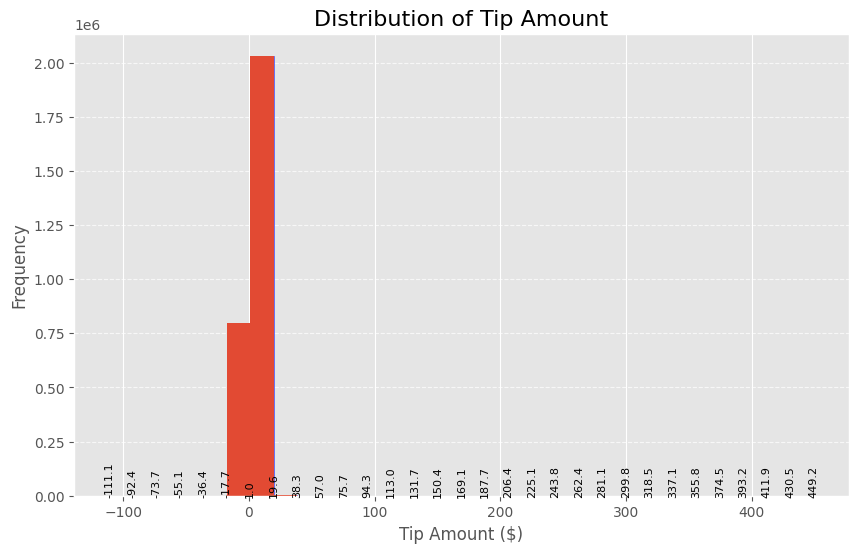

In [29]:
# ดึงข้อมูล Tip_amount
tip_data = df.select("tip_amount").toPandas()

# สร้าง Histogram
plt.figure(figsize=(10, 6))
plt.hist(tip_data["tip_amount"], bins=30, color='lightblue', edgecolor='blue', alpha=0.7)
plt.title("Distribution of Tip Amount", fontsize=16)
plt.xlabel("Tip Amount ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# เพิ่มตัวเลขความถี่บนแท่ง
for bin_edge in plt.hist(tip_data["tip_amount"], bins=30)[1]:
    plt.text(bin_edge, 0, f"{bin_edge:.1f}", fontsize=8, rotation=90, ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


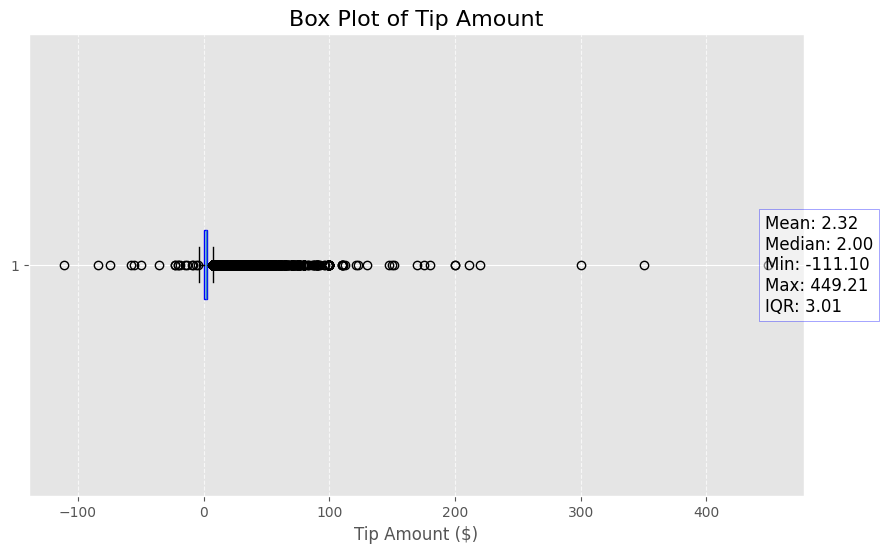

In [30]:
# คำนวณค่าสถิติ
mean_tip = tip_data["tip_amount"].mean()
median_tip = tip_data["tip_amount"].median()
min_tip = tip_data["tip_amount"].min()
max_tip = tip_data["tip_amount"].max()
q1 = tip_data["tip_amount"].quantile(0.25)
q3 = tip_data["tip_amount"].quantile(0.75)
iqr = q3 - q1

# สร้าง Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot(tip_data["tip_amount"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))

# เพิ่มข้อความแสดงค่าสถิติที่มุมขวาบน
plt.text(
    0.95, 0.5, 
    f"Mean: {mean_tip:.2f}\nMedian: {median_tip:.2f}\nMin: {min_tip:.2f}\nMax: {max_tip:.2f}\nIQR: {iqr:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Tip Amount", fontsize=16)
plt.xlabel("Tip Amount ($)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


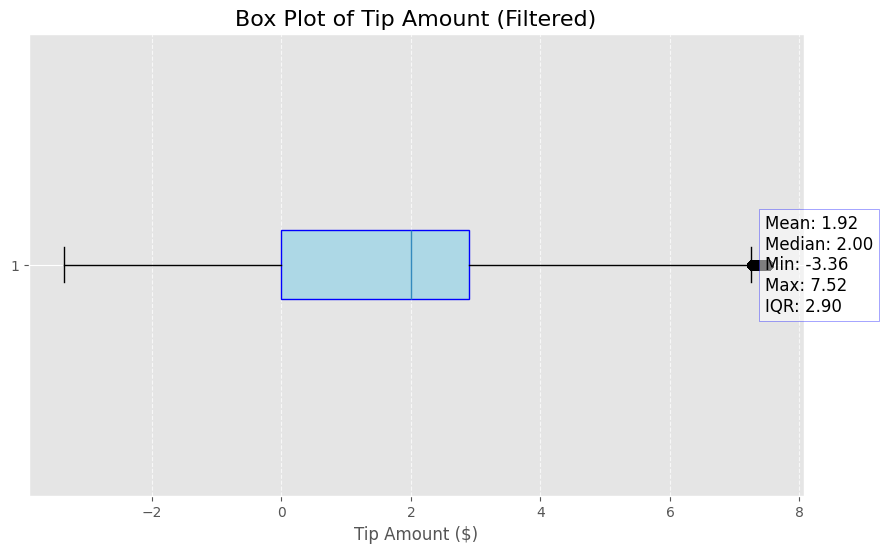

In [31]:
# ดึงข้อมูล tip_amount จาก DataFrame
tip_data = df.select("tip_amount").toPandas()

# คำนวณ IQR เพื่อกรอง Outliers
q1 = tip_data["tip_amount"].quantile(0.25)
q3 = tip_data["tip_amount"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# กรองข้อมูลเพื่อเอา Outliers ออก
filtered_tip_data = tip_data[
    (tip_data["tip_amount"] >= lower_bound) & 
    (tip_data["tip_amount"] <= upper_bound)
]

# คำนวณค่าสถิติหลังกรอง Outliers
mean_tip = filtered_tip_data["tip_amount"].mean()
median_tip = filtered_tip_data["tip_amount"].median()
min_tip = filtered_tip_data["tip_amount"].min()
max_tip = filtered_tip_data["tip_amount"].max()
q1_filtered = filtered_tip_data["tip_amount"].quantile(0.25)
q3_filtered = filtered_tip_data["tip_amount"].quantile(0.75)
iqr_filtered = q3_filtered - q1_filtered

# สร้าง Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_tip_data["tip_amount"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))

# เพิ่มข้อความแสดงค่าสถิติที่มุมขวาบน
plt.text(
    0.95, 0.5, 
    f"Mean: {mean_tip:.2f}\nMedian: {median_tip:.2f}\nMin: {min_tip:.2f}\nMax: {max_tip:.2f}\nIQR: {iqr_filtered:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Tip Amount (Filtered)", fontsize=16)
plt.xlabel("Tip Amount ($)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


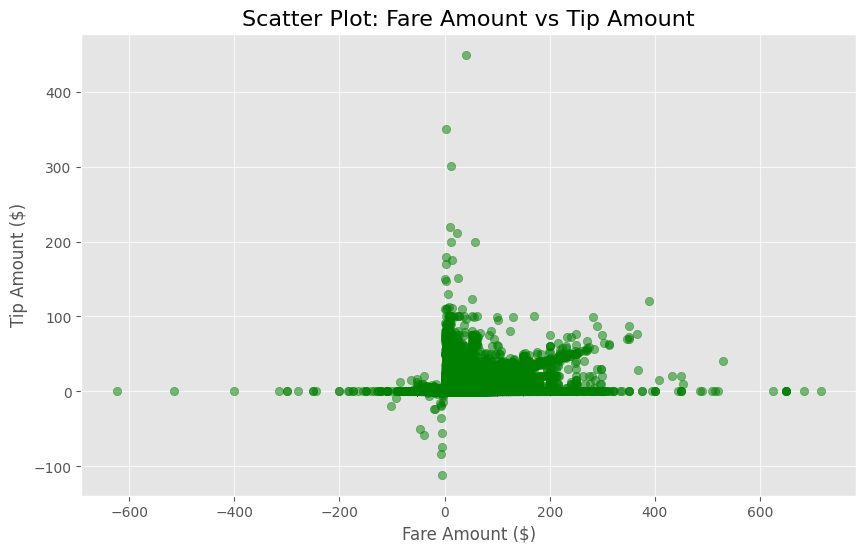

In [32]:
# ดึงข้อมูล Fare_amount และ Tip_amount
fare_tip_data = df.select("fare_amount", "tip_amount").toPandas()

# สร้าง Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(fare_tip_data["fare_amount"], fare_tip_data["tip_amount"], color='green', alpha=0.5)
plt.title("Scatter Plot: Fare Amount vs Tip Amount", fontsize=16)
plt.xlabel("Fare Amount ($)", fontsize=12)
plt.ylabel("Tip Amount ($)", fontsize=12)
plt.grid(alpha=0.7)
plt.show()


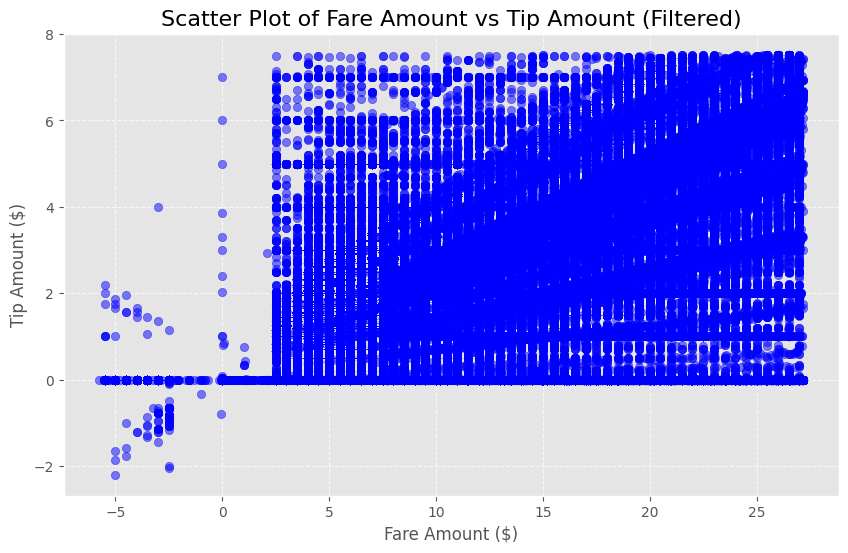

In [33]:
import matplotlib.pyplot as plt

# ดึงข้อมูล fare_amount และ tip_amount จาก DataFrame
fare_tip_data = df.select("fare_amount", "tip_amount").toPandas()

# กรอง Outliers สำหรับ fare_amount
q1_fare = fare_tip_data["fare_amount"].quantile(0.25)
q3_fare = fare_tip_data["fare_amount"].quantile(0.75)
iqr_fare = q3_fare - q1_fare
lower_bound_fare = q1_fare - 1.5 * iqr_fare
upper_bound_fare = q3_fare + 1.5 * iqr_fare

# กรอง Outliers สำหรับ tip_amount
q1_tip = fare_tip_data["tip_amount"].quantile(0.25)
q3_tip = fare_tip_data["tip_amount"].quantile(0.75)
iqr_tip = q3_tip - q1_tip
lower_bound_tip = q1_tip - 1.5 * iqr_tip
upper_bound_tip = q3_tip + 1.5 * iqr_tip

# กรองข้อมูลเพื่อเอา Outliers ออก
filtered_fare_tip_data = fare_tip_data[
    (fare_tip_data["fare_amount"] >= lower_bound_fare) & 
    (fare_tip_data["fare_amount"] <= upper_bound_fare) & 
    (fare_tip_data["tip_amount"] >= lower_bound_tip) & 
    (fare_tip_data["tip_amount"] <= upper_bound_tip)
]

# สร้าง Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_fare_tip_data["fare_amount"], filtered_fare_tip_data["tip_amount"], alpha=0.5, color="blue")
plt.title("Scatter Plot of Fare Amount vs Tip Amount (Filtered)", fontsize=16)
plt.xlabel("Fare Amount ($)", fontsize=12)
plt.ylabel("Tip Amount ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Tolls_amount

In [34]:
from pyspark.sql.functions import when

# สร้างคอลัมน์ Tolls_YN
df_with_tolls_yn = df.withColumn(
    "Tolls_YN",
    when(df["tolls_amount"] > 0, "Yes").otherwise("No")
)

# นับจำนวน Yes/No
tolls_yn_summary = (
    df_with_tolls_yn.groupBy("Tolls_YN")
    .count()
    .orderBy("Tolls_YN")
    .toPandas()
)

# คำนวณเปอร์เซ็นต์
total_count = tolls_yn_summary["count"].sum()
tolls_yn_summary["Percentage (%)"] = (tolls_yn_summary["count"] / total_count) * 100

# แสดงผล
print("Summary of Tolls Usage (Yes/No):")
print(tolls_yn_summary)


Summary of Tolls Usage (Yes/No):
  Tolls_YN    count  Percentage (%)
0       No  2686439        94.78436
1      Yes   147825         5.21564


## Total_amount

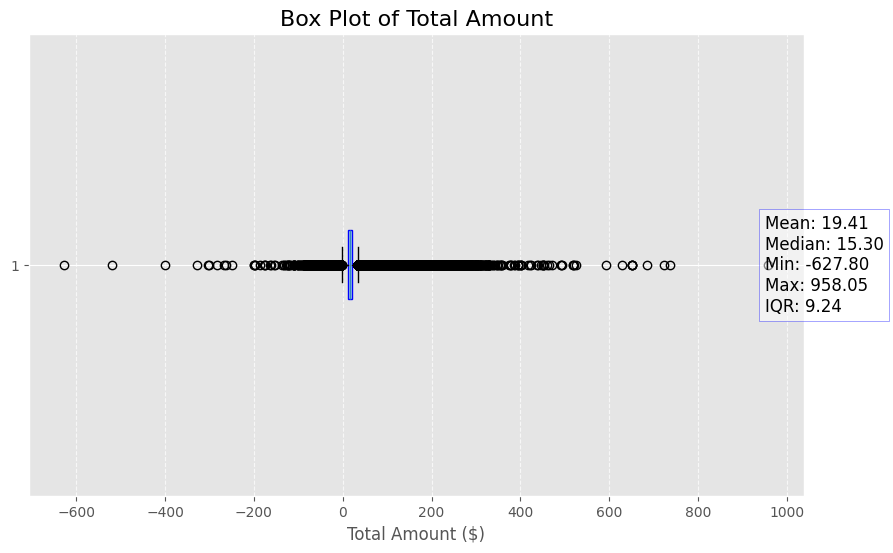

In [35]:
# ดึงข้อมูล Total_amount
total_data = df.select("total_amount").toPandas()

# คำนวณค่าสถิติที่สำคัญ
mean_total = total_data["total_amount"].mean()
median_total = total_data["total_amount"].median()
min_total = total_data["total_amount"].min()
max_total = total_data["total_amount"].max()
q1 = total_data["total_amount"].quantile(0.25)
q3 = total_data["total_amount"].quantile(0.75)
iqr = q3 - q1

# สร้าง Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot(total_data["total_amount"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))

# เพิ่มข้อความแสดงค่าสถิติที่มุมขวาบน
plt.text(
    0.95, 0.5, 
    f"Mean: {mean_total:.2f}\nMedian: {median_total:.2f}\nMin: {min_total:.2f}\nMax: {max_total:.2f}\nIQR: {iqr:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Total Amount", fontsize=16)
plt.xlabel("Total Amount ($)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


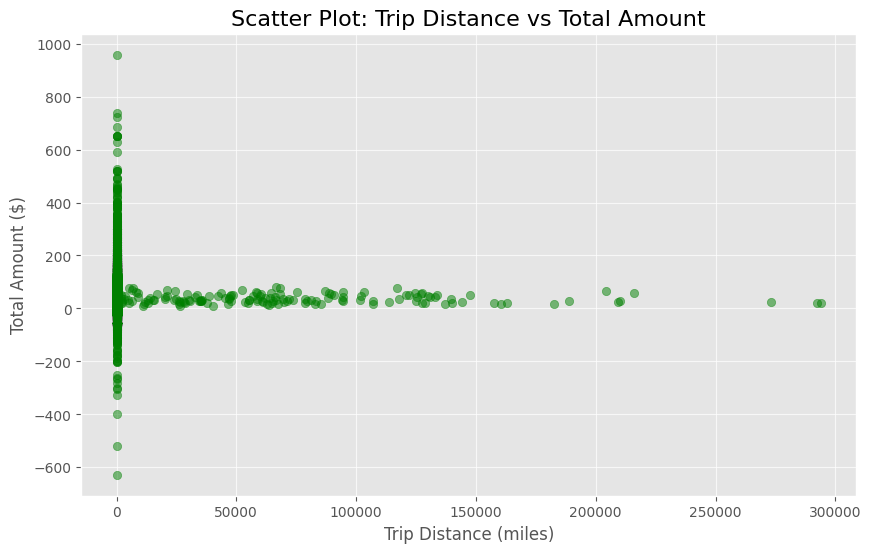

In [36]:
# ดึงข้อมูล Total_amount และ Trip_distance
distance_total_data = df.select("trip_distance", "total_amount").toPandas()

# สร้าง Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(distance_total_data["trip_distance"], distance_total_data["total_amount"], color='green', alpha=0.5)
plt.title("Scatter Plot: Trip Distance vs Total Amount", fontsize=16)
plt.xlabel("Trip Distance (miles)", fontsize=12)
plt.ylabel("Total Amount ($)", fontsize=12)
plt.grid(alpha=0.7)
plt.show()


## Congestion_Surcharge

In [37]:

# สร้าง Category สำหรับ Congestion_Surcharge
df_with_congestion_category = df.withColumn(
    "Congestion_Category",
    when(col("congestion_surcharge") == 2.75, "Standard ($2.75)")
    .when(col("congestion_surcharge") == 0.0, "No Charge ($0.0)")
    .otherwise("Other")
)

# นับจำนวนและคำนวณเปอร์เซ็นต์
congestion_summary = (
    df_with_congestion_category.groupBy("Congestion_Category")
    .count()
    .orderBy("Congestion_Category")
    .toPandas()
)

# คำนวณเปอร์เซ็นต์
total_count = congestion_summary["count"].sum()
congestion_summary["Percentage (%)"] = (congestion_summary["count"] / total_count) * 100

# แสดงผล
print("Congestion Surcharge Summary:")
print(congestion_summary)

Congestion Surcharge Summary:
  Congestion_Category    count  Percentage (%)
0    No Charge ($0.0)   202460        7.143301
1               Other  2631803       92.856664
2    Standard ($2.75)        1        0.000035


In [38]:
# ดึงข้อมูล Congestion_Surcharge
congestion_data = df.select("congestion_surcharge").toPandas()

# คำนวณค่าสถิติที่สำคัญ
mean_congestion = congestion_data["congestion_surcharge"].mean()
median_congestion = congestion_data["congestion_surcharge"].median()
min_congestion = congestion_data["congestion_surcharge"].min()
max_congestion = congestion_data["congestion_surcharge"].max()
q1_congestion = congestion_data["congestion_surcharge"].quantile(0.25)
q3_congestion = congestion_data["congestion_surcharge"].quantile(0.75)
iqr_congestion = q3_congestion - q1_congestion

# แสดงค่าสถิติ
print(f"Mean: {mean_congestion:.2f}")
print(f"Median: {median_congestion:.2f}")
print(f"Min: {min_congestion:.2f}")
print(f"Max: {max_congestion:.2f}")
print(f"Q1: {q1_congestion:.2f}")
print(f"Q3: {q3_congestion:.2f}")
print(f"IQR: {iqr_congestion:.2f}")


Mean: 2.29
Median: 2.50
Min: -2.50
Max: 2.75
Q1: 2.50
Q3: 2.50
IQR: 0.00


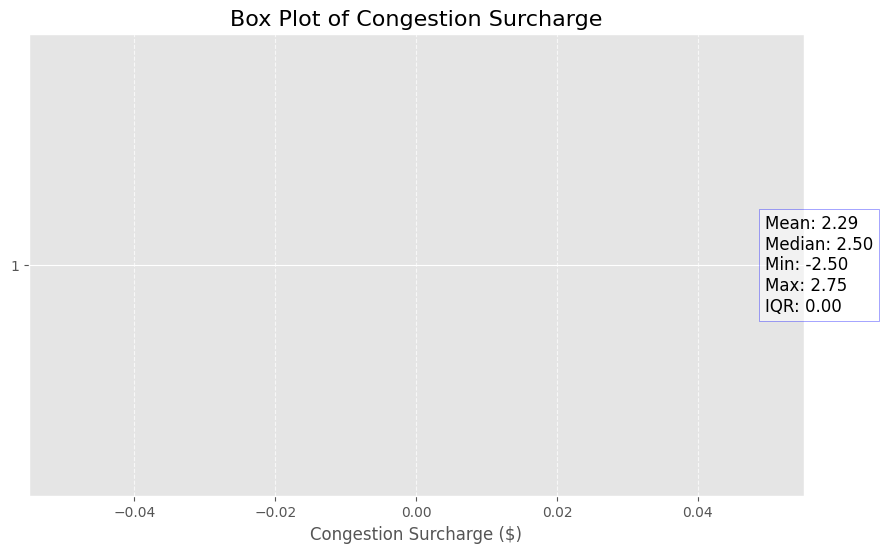

In [39]:
import matplotlib.pyplot as plt

# สร้าง Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot(congestion_data["congestion_surcharge"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))

# เพิ่มข้อความแสดงค่าสถิติที่มุมขวาบน
plt.text(
    0.95, 0.5, 
    f"Mean: {mean_congestion:.2f}\nMedian: {median_congestion:.2f}\nMin: {min_congestion:.2f}\nMax: {max_congestion:.2f}\nIQR: {iqr_congestion:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Congestion Surcharge", fontsize=16)
plt.xlabel("Congestion Surcharge ($)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


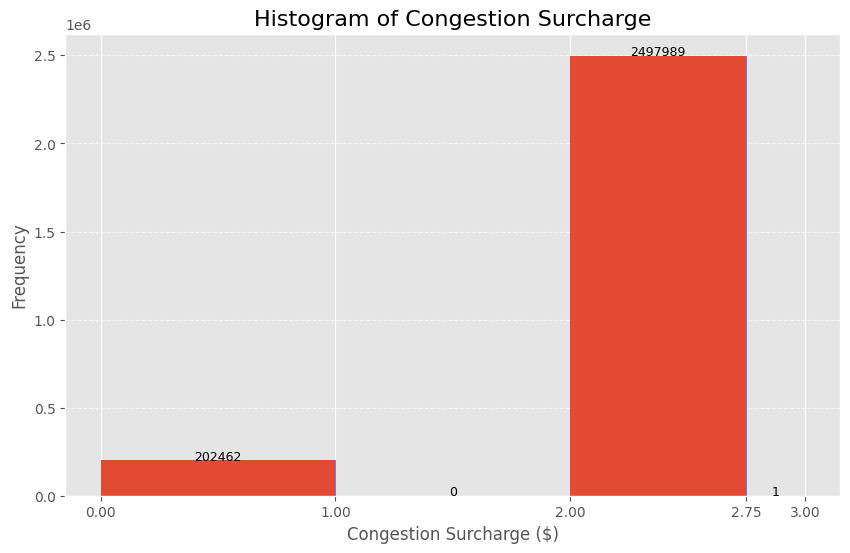

In [40]:
import matplotlib.pyplot as plt

# ดึงข้อมูล Congestion_Surcharge
congestion_data = df.select("congestion_surcharge").toPandas()

# สร้าง Histogram
plt.figure(figsize=(10, 6))
bins = [0.0, 1.0, 2.0, 2.75, 3.0]  # กำหนด Bins ให้เหมาะสมตามค่าที่พบ
plt.hist(congestion_data["congestion_surcharge"], bins=bins, color='skyblue', edgecolor='blue', alpha=0.7)

# เพิ่มตัวเลขความถี่บนแท่ง Histogram
bin_edges = plt.hist(congestion_data["congestion_surcharge"], bins=bins)[1]
for i in range(len(bin_edges) - 1):
    bin_center = (bin_edges[i] + bin_edges[i + 1]) / 2
    count = len(congestion_data[(congestion_data["congestion_surcharge"] >= bin_edges[i]) & 
                                (congestion_data["congestion_surcharge"] < bin_edges[i + 1])])
    plt.text(bin_center, count + 10, str(count), ha='center', fontsize=9)

# ตั้งค่ากราฟ
plt.title("Histogram of Congestion Surcharge", fontsize=16)
plt.xlabel("Congestion Surcharge ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(bins)
plt.show()


## Airport_fee 

In [41]:
# นับจำนวนในแต่ละ category ของ airport_fee
airport_fee_count = df.groupBy("airport_fee").count().orderBy("airport_fee").toPandas()

# คำนวณเปอร์เซ็นต์
total_count = airport_fee_count["count"].sum()
airport_fee_count["Percentage (%)"] = (airport_fee_count["count"] / total_count) * 100

# แสดงผล
print("Airport Fee Counts by Category:")
print(airport_fee_count)


Airport Fee Counts by Category:
   airport_fee    count  Percentage (%)
0          NaN   123538        4.358733
1        -1.25      668        0.023569
2         0.00  2574079       90.820015
3         1.25   135979        4.797683


In [42]:
# Filter DataFrame for rows where airport_fee is -1.25 and select distinct PULocationID
distinct_pulocationid = df.filter(df["airport_fee"] == -1.25).select("PULocationID").distinct()

# Show the result
distinct_pulocationid.show()


+------------+
|PULocationID|
+------------+
|         264|
|         144|
|          43|
|         193|
|         107|
|         158|
|         234|
|         239|
|          79|
|         138|
|          10|
|          48|
|         142|
|         100|
|         132|
|         141|
|         164|
|         230|
|         163|
|         140|
+------------+
only showing top 20 rows



In [43]:
# ดึงข้อมูล Airport_fee
airport_fee_data = df.select("airport_fee").toPandas()

# คำนวณค่าสถิติที่สำคัญ
mean_airport = airport_fee_data["airport_fee"].mean()
median_airport = airport_fee_data["airport_fee"].median()
min_airport = airport_fee_data["airport_fee"].min()
max_airport = airport_fee_data["airport_fee"].max()
q1_airport = airport_fee_data["airport_fee"].quantile(0.25)
q3_airport = airport_fee_data["airport_fee"].quantile(0.75)
iqr_airport = q3_airport - q1_airport

# แสดงค่าสถิติ
print(f"Mean: {mean_airport:.2f}")
print(f"Median: {median_airport:.2f}")
print(f"Min: {min_airport:.2f}")
print(f"Max: {max_airport:.2f}")
print(f"Q1: {q1_airport:.2f}")
print(f"Q3: {q3_airport:.2f}")
print(f"IQR: {iqr_airport:.2f}")


Mean: 0.06
Median: 0.00
Min: -1.25
Max: 1.25
Q1: 0.00
Q3: 0.00
IQR: 0.00


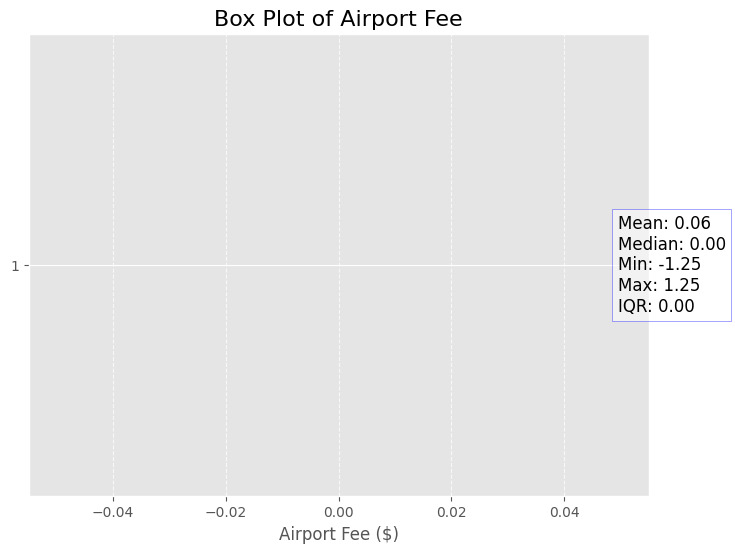

In [44]:
# สร้าง Box Plot
plt.figure(figsize=(8, 6))
plt.boxplot(airport_fee_data["airport_fee"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'))

# เพิ่มข้อความแสดงค่าสถิติที่มุมขวาบน
plt.text(
    0.95, 0.5, 
    f"Mean: {mean_airport:.2f}\nMedian: {median_airport:.2f}\nMin: {min_airport:.2f}\nMax: {max_airport:.2f}\nIQR: {iqr_airport:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.5)
)

# ตั้งค่ากราฟ
plt.title("Box Plot of Airport Fee", fontsize=16)
plt.xlabel("Airport Fee ($)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## Overall

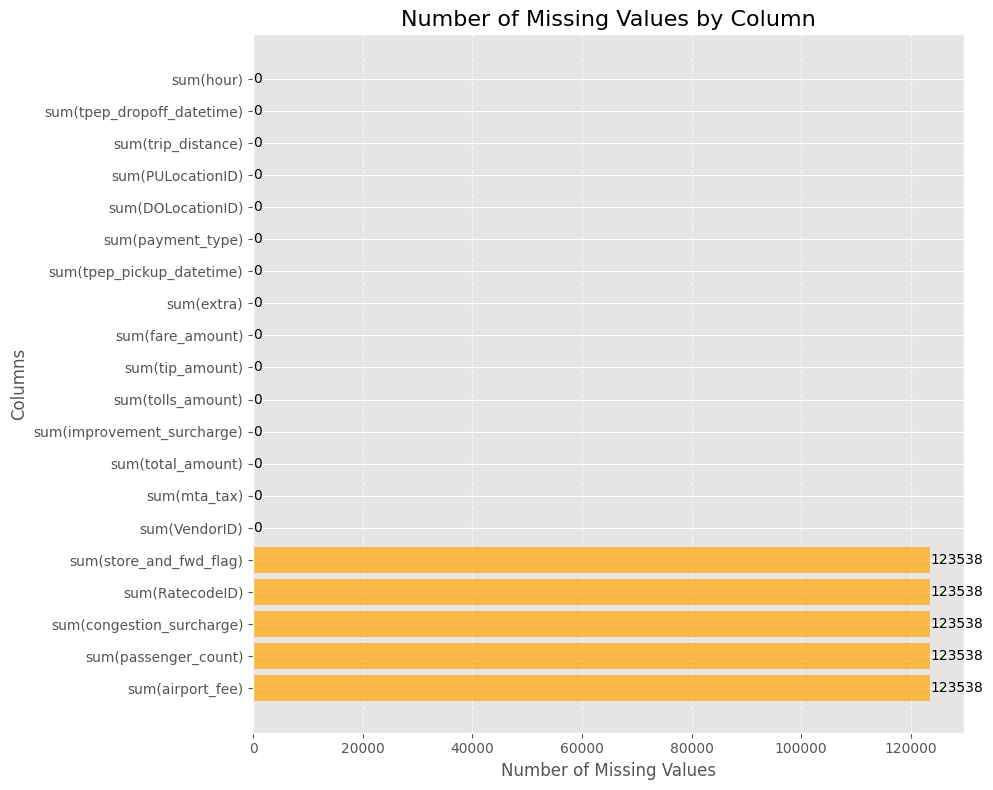

In [45]:
from pyspark.sql.functions import col, sum

# คำนวณจำนวน Missing Values (NULL) ในแต่ละ Column
missing_values = (
    df.select([col(c).isNull().cast("int").alias(c) for c in df.columns])
    .groupBy()
    .sum()
    .toPandas()
)

# แปลง DataFrame เพื่อสร้างกราฟ
missing_values = missing_values.T.reset_index()
missing_values.columns = ["Column", "Missing Values"]
missing_values = missing_values.sort_values(by="Missing Values", ascending=False)

# สร้าง Bar Chart แนวนอน
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(missing_values["Column"], missing_values["Missing Values"], color='orange', alpha=0.7)

# เพิ่มตัวเลขบนแถบ
for index, value in enumerate(missing_values["Missing Values"]):
    plt.text(value + 10, index, str(value), va='center', fontsize=10)

# ตั้งค่ากราฟ
plt.title("Number of Missing Values by Column", fontsize=16)
plt.xlabel("Number of Missing Values", fontsize=12)
plt.ylabel("Columns", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


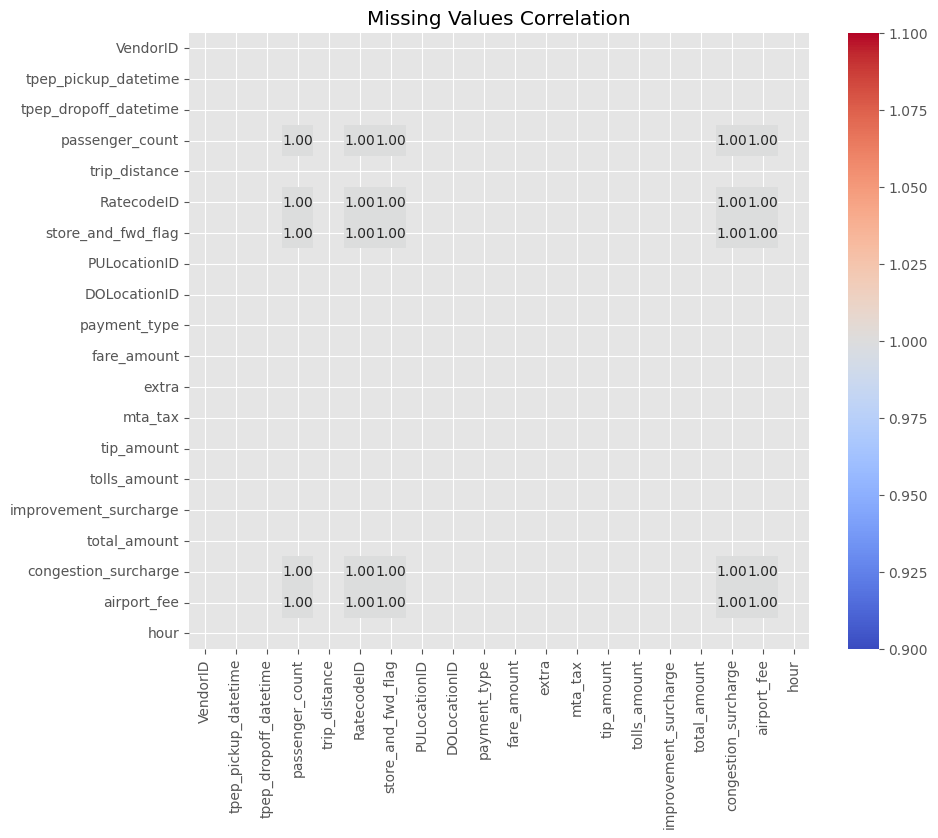

In [46]:

# คำนวณ Missing Values
missing_matrix = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]).toPandas()

# สร้าง Heatmap ของ Missing Value Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(missing_matrix.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Missing Values Correlation")
plt.show()

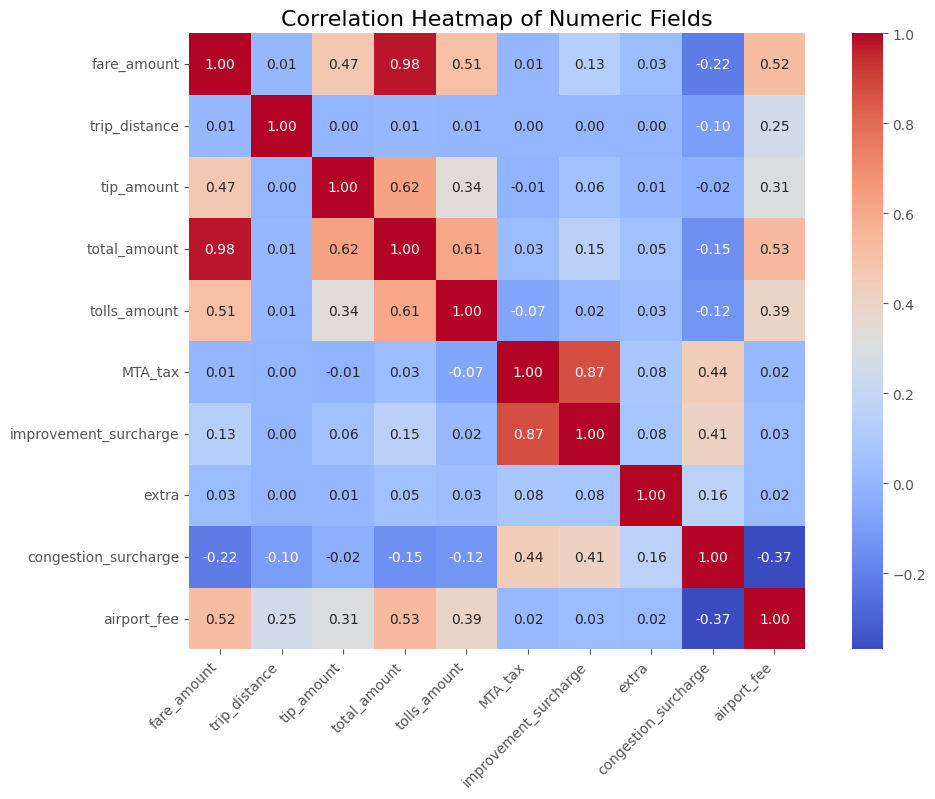

In [47]:
# เลือกเฉพาะ numeric fields จาก Spark DataFrame
numeric_columns = [
    "fare_amount", "trip_distance", "tip_amount", "total_amount",
    "tolls_amount", "MTA_tax", "improvement_surcharge", "extra",
    "congestion_surcharge", "airport_fee"
]

# แปลง Spark DataFrame เป็น Pandas DataFrame
numeric_data = df.select(numeric_columns).toPandas()

# คำนวณ Correlation Matrix
correlation_matrix = numeric_data.corr()

# สร้าง Heatmap ด้วย Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap of Numeric Fields", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


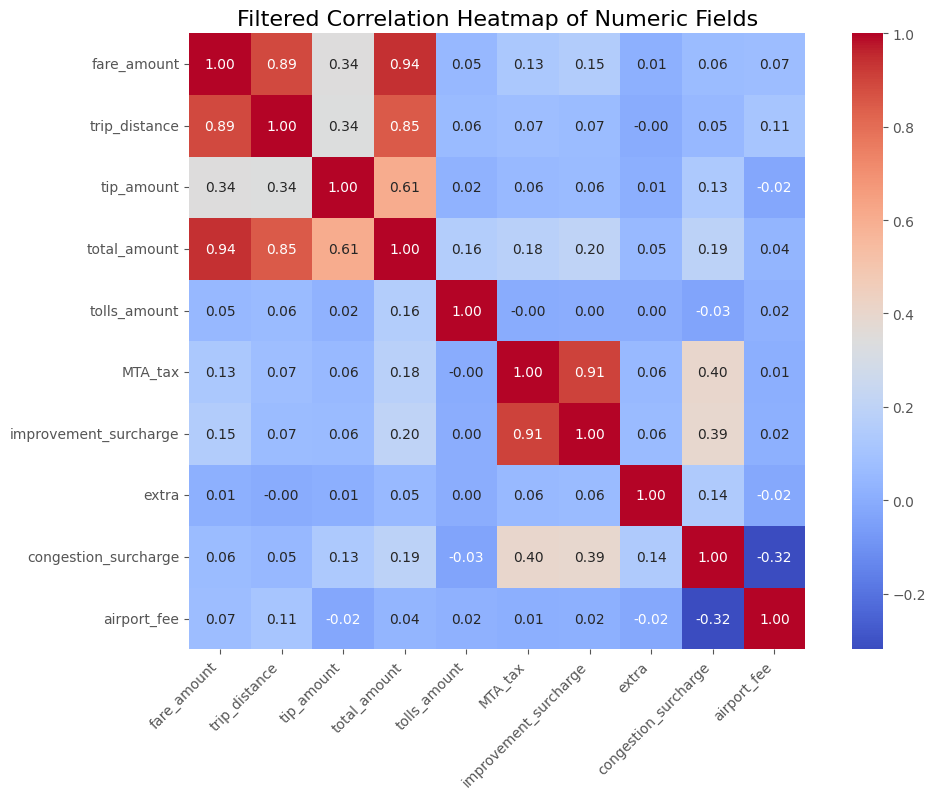

In [48]:
# กรอง Outliers ของ trip_distance และ fare_amount
q1_distance = numeric_data["trip_distance"].quantile(0.25)
q3_distance = numeric_data["trip_distance"].quantile(0.75)
iqr_distance = q3_distance - q1_distance
lower_distance = q1_distance - 1.5 * iqr_distance
upper_distance = q3_distance + 1.5 * iqr_distance

q1_fare = numeric_data["fare_amount"].quantile(0.25)
q3_fare = numeric_data["fare_amount"].quantile(0.75)
iqr_fare = q3_fare - q1_fare
lower_fare = q1_fare - 1.5 * iqr_fare
upper_fare = q3_fare + 1.5 * iqr_fare

# กรองข้อมูล
filtered_data = numeric_data[
    (numeric_data["trip_distance"] > lower_distance) &
    (numeric_data["trip_distance"] < upper_distance) &
    (numeric_data["fare_amount"] > lower_fare) &
    (numeric_data["fare_amount"] < upper_fare)
]

# คำนวณ correlation matrix ใหม่
filtered_correlation_matrix = filtered_data.corr()

# สร้าง Heatmap ใหม่
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Filtered Correlation Heatmap of Numeric Fields", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


In [50]:
from pyspark.sql.functions import col
from functools import reduce

# Filter only the relevant columns
columns_to_sum = [
    "fare_amount", "extra", "mta_tax", "tip_amount", 
    "tolls_amount", "improvement_surcharge", "congestion_surcharge", "airport_fee"
]

# Add a new column 'sum_value' by summing up all the relevant columns
df_with_sum = df.withColumn(
    "sum_value",
    reduce(lambda a, b: a + b, [col(c) for c in columns_to_sum])
)

# Show the resulting DataFrame
df_with_sum.select("total_amount", "sum_value","fare_amount", "extra", "mta_tax", "tip_amount", 
    "tolls_amount", "improvement_surcharge", "congestion_surcharge", "airport_fee").show(50)


+------------+------------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+
|total_amount|         sum_value|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|congestion_surcharge|airport_fee|
+------------+------------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+
|        11.0|              13.5|        5.0|  3.0|    0.5|       2.2|         0.0|                  0.3|                 2.5|        0.0|
|        70.6|             71.85|       61.5| 1.75|    0.5|       0.0|        6.55|                  0.3|                 0.0|       1.25|
|        7.55|               8.8|        5.0| 1.75|    0.5|       0.0|         0.0|                  0.3|                 0.0|       1.25|
|       42.55|              43.8|       31.5| 1.75|    0.5|       8.5|         0.0|                  0.3|                 0.0|       1.25|
|       47.87| 47.869999999

In [51]:
# Define the columns to sum up
columns_to_sum = [
    "fare_amount", "extra", "mta_tax", "tip_amount", 
    "tolls_amount", "improvement_surcharge", "congestion_surcharge", "airport_fee"
]

# Add a new column 'sum_value' by summing up all the relevant columns
df_with_sum = df.withColumn(
    "sum_value",
    reduce(lambda a, b: a + b, [col(c) for c in columns_to_sum])
)

# Show the resulting DataFrame including payment_type
df_with_sum.select(
    "total_amount", "sum_value", "payment_type", 
    "fare_amount", "extra", "mta_tax", "tip_amount", 
    "tolls_amount", "improvement_surcharge", "congestion_surcharge", "airport_fee"
).show(50)


+------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+
|total_amount|         sum_value|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|congestion_surcharge|airport_fee|
+------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+-----------+
|        11.0|              13.5|           1|        5.0|  3.0|    0.5|       2.2|         0.0|                  0.3|                 2.5|        0.0|
|        70.6|             71.85|           2|       61.5| 1.75|    0.5|       0.0|        6.55|                  0.3|                 0.0|       1.25|
|        7.55|               8.8|           2|        5.0| 1.75|    0.5|       0.0|         0.0|                  0.3|                 0.0|       1.25|
|       42.55|              43.8|           1|       31.5| 1.75|    0.5|       8.5|     